# PRK-Stencil

## TODO: 
- Legends are wrong for lineplots, etc
- Find more colorings that look good

## Some rough term explanations that get used in the comments

- Dataframe: Two-dimensional data structure that stores different kinds of data in rows and columns, basically a table (often named df, or uses df as a prefix etc.). Provided by the pandas library
- Feature: A column of a dataframe

## Imports and dataframe

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

In [2]:
#Read csv and create a dataframe
df = pd.read_csv('stencil_2.csv')

# Calculate slowdown, and tool slowdown
#df["slowdown"] = [row["avg_t(s)"]/df.loc[(df['compile'] == "base") & (df['measurement'] == "base") & (df['tasks'] == df['tasks'].min())]["avg_t(s)"].iloc[0] for index, row in df.iterrows()]
df["tool slowdown"] = [row["avg_t(s)"]/df.loc[(df['compile'] == "base") & (df['measurement'] == "base") & (df['tasks'] == row['tasks'])]["avg_t(s)"].iloc[0] for index, row in df.iterrows()]

# Create the new feature "compile:measurement" that is the combination of the "compile" and "measurement" features.
# We use this later for the "hue" arguement in the seaborn plotting functions, which creates a color encoding based 
#on the values of the "compile:measurement" feature. e.g. the data points for "base:base" and "tsan:must" will have different colors
df["compile:measurement"] = df["compile"] + ":" + df["measurement"]
display(df)

# Drop "base:must" because it is not of interest
df = df.drop(df[df["compile:measurement"] == "base:must"].index)

time_col = "avg_t(s)"
slowdown_col = "tool slowdown"

bench_id compile measurement  tasks  num_iters  grid_size  avg_t(s)  \
0         41    base        base     24        400      20000  0.093211   
1         41    base        must     24        400      20000  0.101288   
2         41    tsan        base     24        400      20000  0.876520   
3         41    tsan        must     24        400      20000  1.474257   
4         41    base        base     48        400      20000  0.045422   
5         41    base        must     48        400      20000  0.053436   
6         41    tsan        base     48        400      20000  0.626195   
7         41    tsan        must     48        400      20000  0.770547   
8         41    base        base     96        400      20000  0.022924   
9         41    base        must     96        400      20000  0.033269   
10        41    tsan        base     96        400      20000  0.287862   
11        41    tsan        must     96        400      20000  0.409369   
12        41    base        base    192        400      20000  0.011040   
13        41    base        must    192        400      20000  0.029213   
14        41    tsan        base    192        400      20000  0.155908   
15        41    tsan        must    192        400      20000  0.209394   
16        41    base        base    384        400      20000  0.005288   
17        41    base        must    384        400      20000  0.035963   
18        41    tsan        base    384        400      20000  0.079069   
19        41    tsan        must    384        400      20000  0.121535   

    rate (MFlops/s)  tool slowdown compile:measurement  
0      47195.414773       1.000000           base:base  
1      43431.658425       1.086653           base:must  
2       5018.848593       9.403611           tsan:base  
3       2983.956428      15.816341           tsan:must  
4      96850.042577       1.000000           base:base  
5      82324.290675       1.176434           base:must  
6       7025.158598      13.786161           tsan:base  
7       5709.090651      16.964180           tsan:must  
8     191899.157068       1.000000           base:base  
9     132227.502774       1.451274           base:must  
10     15282.055308      12.557233           tsan:base  
11     10746.112400      17.857660           tsan:must  
12    398474.354788       1.000000           base:base  
13    150587.148007       2.646105           base:must  
14     28216.100553      14.122101           tsan:base  
15     21008.772344      18.966848           tsan:must  
16    831945.953164       1.000000           base:base  
17    122325.029349       6.800870           base:must  
18     55636.650885      14.952534           tsan:base  
19     36196.216854      22.983169           tsan:must

# Plotting code

In [3]:
custom = {"grid.linestyle": "solid", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)

fontdict =  {
             'fontsize': 18,
             'fontweight': 'light',
             'color': 'black'}
#palettes
colorful = ["#407fb7", "#c74e69", "#f9c24c"]
grey_colorful = ["#d3d3d3", "#c74e69", "#f9c24c"]
greyscale = ["#d3d3d3", "#999999", "#5e5e5e"]
black = ["black", "black", "black"]

#hatches
hatch_none = ["", "", ""]
hatch_last = ["", "", "\\\\"]
   
def lineplot(ax, target, **kwargs):
    del kwargs["hatch"]
    #Normally you need to specify a "data" parameter that you provide your dataframe to. Here the "data" parameter is (expected to be) part of kwargs
    sns.lineplot(x="tasks", y=target, hue="compile:measurement", ax=ax, **kwargs)
    ax.set_zorder(100)
    
def scatterplot(ax, target, **kwargs):
    sns.scatterplot(x="tasks", y=target, hue="compile:measurement", ax=ax, **kwargs)
    ax.set_zorder(100)

def pointplot(ax, target, **kwargs):
    sns.pointplot(x="tasks", y=target, hue="compile:measurement", ax=ax, **kwargs)
    ax.set_zorder(100)
    
def cat_lineplot(ax, target, **kwargs):
    #Change x values to [0, ..., number of unique "tasks" values], and set the tick labels to the original tasks values
    tmp = kwargs["data"].copy()
    ax.set_xticks(np.arange(tmp["tasks"].nunique()), labels=tmp["tasks"].unique()) # set x ticks and labels
    tasks = []
    for index, row in tmp.iterrows():
        for i, n in enumerate(tmp["tasks"].unique()):
            if n == row["tasks"]:
                tasks.append(i)
    tmp["tasks"] = tasks
    kwargs["data"] = tmp    
    
    lineplot(ax, target, **kwargs)
    

def grouped_barplot(ax, target, **kwargs):  
    h=kwargs["hatch"]
    del kwargs["hatch"]     
    
    sns.barplot(x="tasks", y=target, hue="compile:measurement", ax=ax, **kwargs) 
    
    j=0
    hatch=h[0]
    ntasks = kwargs["data"]["tasks"].nunique()
    for i, bar in enumerate(ax.patches):
        if i%ntasks == 0:
            hatch = h[j%len(h)]
            j+=1
        bar.set_hatch(hatch)
        
    for i in ax.containers:
        texts = ax.bar_label(i, fmt='%.3g', rotation=90)
        for text in texts:
            text.set(y=5, zorder=2000)

def overlapping_barplot(ax, target, **kwargs):
    tmp = kwargs["data"].copy().sort_values(by=target, ascending=False)
    kwargs.update({"dodge": False, "data": tmp})   
    kwargs["palette"] = kwargs["palette"].copy()
    kwargs["palette"].reverse()   
    kwargs["hatch"] = kwargs["hatch"].copy()
    kwargs["hatch"].reverse()
    grouped_barplot(ax, target, **kwargs)
        
        
# function for plotting
# runtime and slowdown expect one of the above functions
def plot(runtime=overlapping_barplot, slowdown=pointplot, data=df, primary="runtime", runtime_kwargs=None, slowdown_kwargs=None, **kwargs):
    #Create new dictionaries if they were not provided, necessary for reseting the input for subsequent calls
    if runtime_kwargs is None:
        runtime_kwargs = {}
    if slowdown_kwargs is None:
        slowdown_kwargs = {}
    #create dicts with default values   
    truntime_kwargs =  {"palette": colorful, "data": data, "hatch":hatch_none }
    tslowdown_kwargs = {"palette": colorful, "data": data, "hatch":hatch_none }
    #update default values with given values
    truntime_kwargs.update(**kwargs)
    truntime_kwargs.update(runtime_kwargs)
    tslowdown_kwargs.update(**kwargs)
    tslowdown_kwargs.update(slowdown_kwargs)
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 10))     
    #create two new axes, and use ax as an empty axis for the background
    ax1=ax.twinx()
    ax2=ax1.twinx()
    #move ticks and label to the left y-axis
    ax1.yaxis.tick_left()
    ax1.yaxis.set_label_position("left")
    
    # remove the ticks and labels of the background axis
    ax.tick_params(left=False, labelleft = False) 
    
    #Remove background of ax1 and ax2
    ax1.patch.set_visible(False)
    ax2.patch.set_visible(False)
    #Remove grids of ax1 and ax2
    ax1.grid(False)
    ax2.grid(False)
    
    #Set ticks and limits of the background axis ax to the respective values of axis ax1
    ax.set_yticks(ax1.get_yticks())
    ax.set_ylim(ax1.get_ylim()) 
    
    #Plot title, currently fixed...
    ax.set_title("PRK-Stencil: #tasks vs. runtime and slowdown", loc = "left", fontdict = fontdict)
    #Axis labels
    ax.set_xlabel("# Tasks")
    ax1.set_ylabel("Runtime [s]")
    ax2.set_ylabel(slowdown_col)
    if primary.lower() == "slowdown":
        ax1.set_ylabel(slowdown_col)
        ax2.set_ylabel("Runtime [s]")
    
    #Plot runtime and slowdown
    if runtime:
        #plot runtime
        runtime(ax1, time_col, **truntime_kwargs)
        #create runtime legend
        ax1.legend(loc='lower left', bbox_to_anchor=(0, -.18), title="runtime")  
    if slowdown:
        tmp = tslowdown_kwargs["data"].copy()
        # "base:base" is always 1, and thus not really relevant to plot
        tslowdown_kwargs["data"] = tmp.drop(tmp[tmp["compile:measurement"] == "base:base"].index)
        tslowdown_kwargs["palette"] = tslowdown_kwargs["palette"][1:]
        tslowdown_kwargs["hatch"] = tslowdown_kwargs["hatch"][1:]
        #plot slowdown
        slowdown(ax2, slowdown_col, **tslowdown_kwargs) 
        #create slowdown legend
        ax2.legend(loc='lower right', bbox_to_anchor=(1, -.18),title=slowdown_col)
    
    plt.show()


# Numneric

## Scatterplot

<Figure size 640x480 with 0 Axes>

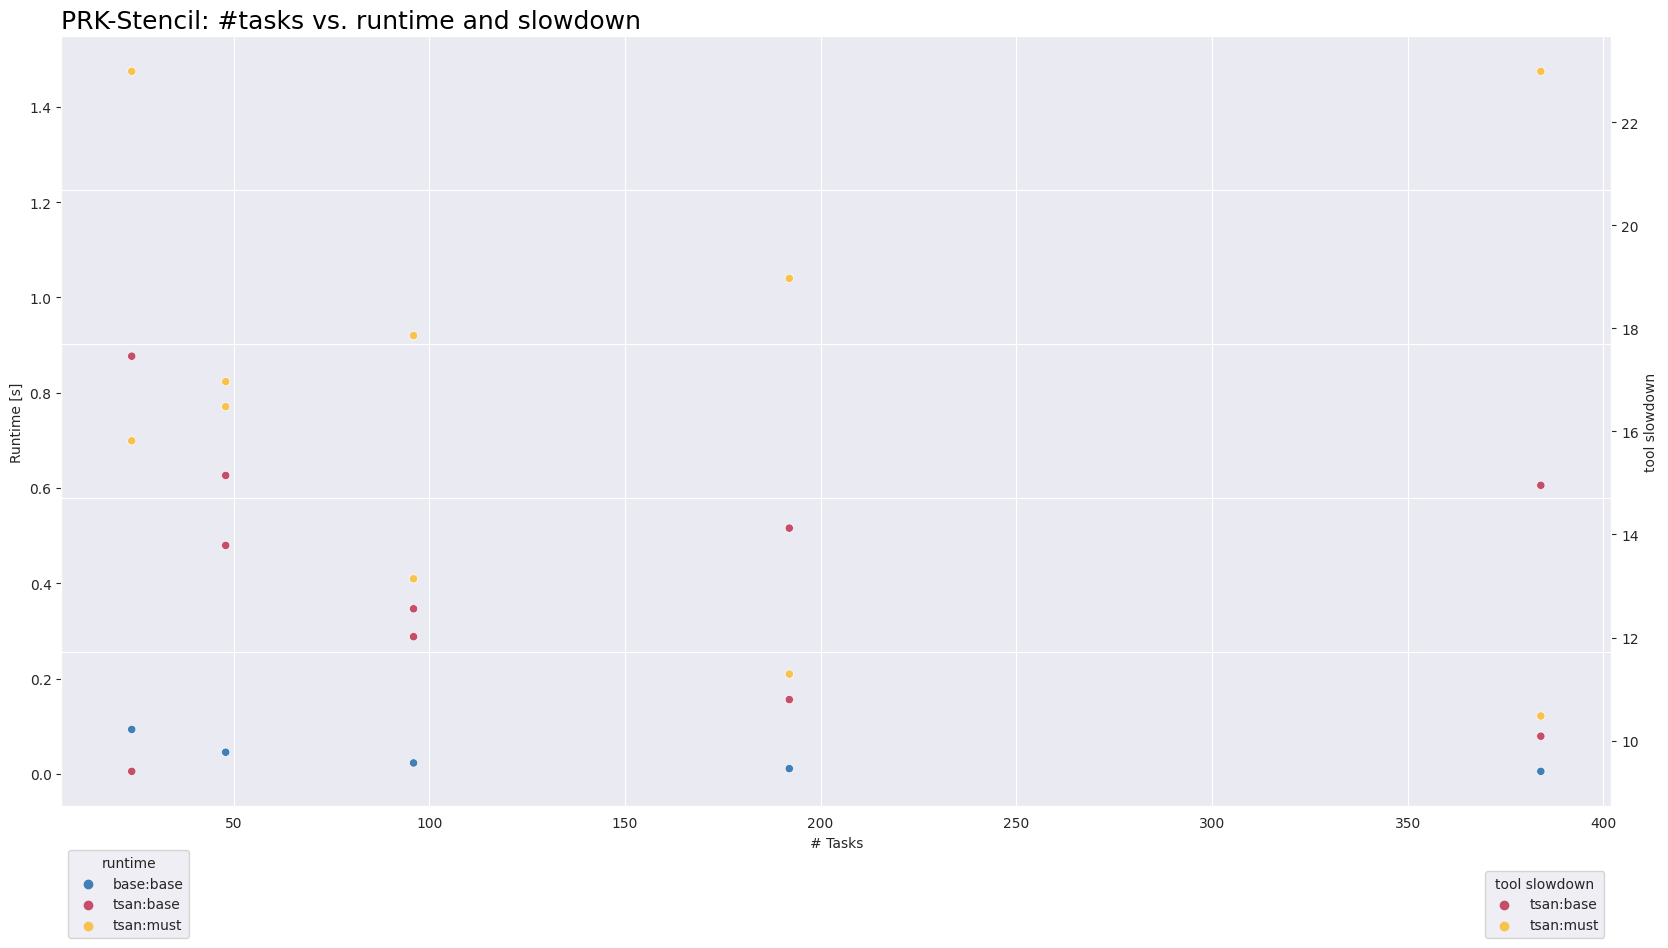

<Figure size 640x480 with 0 Axes>

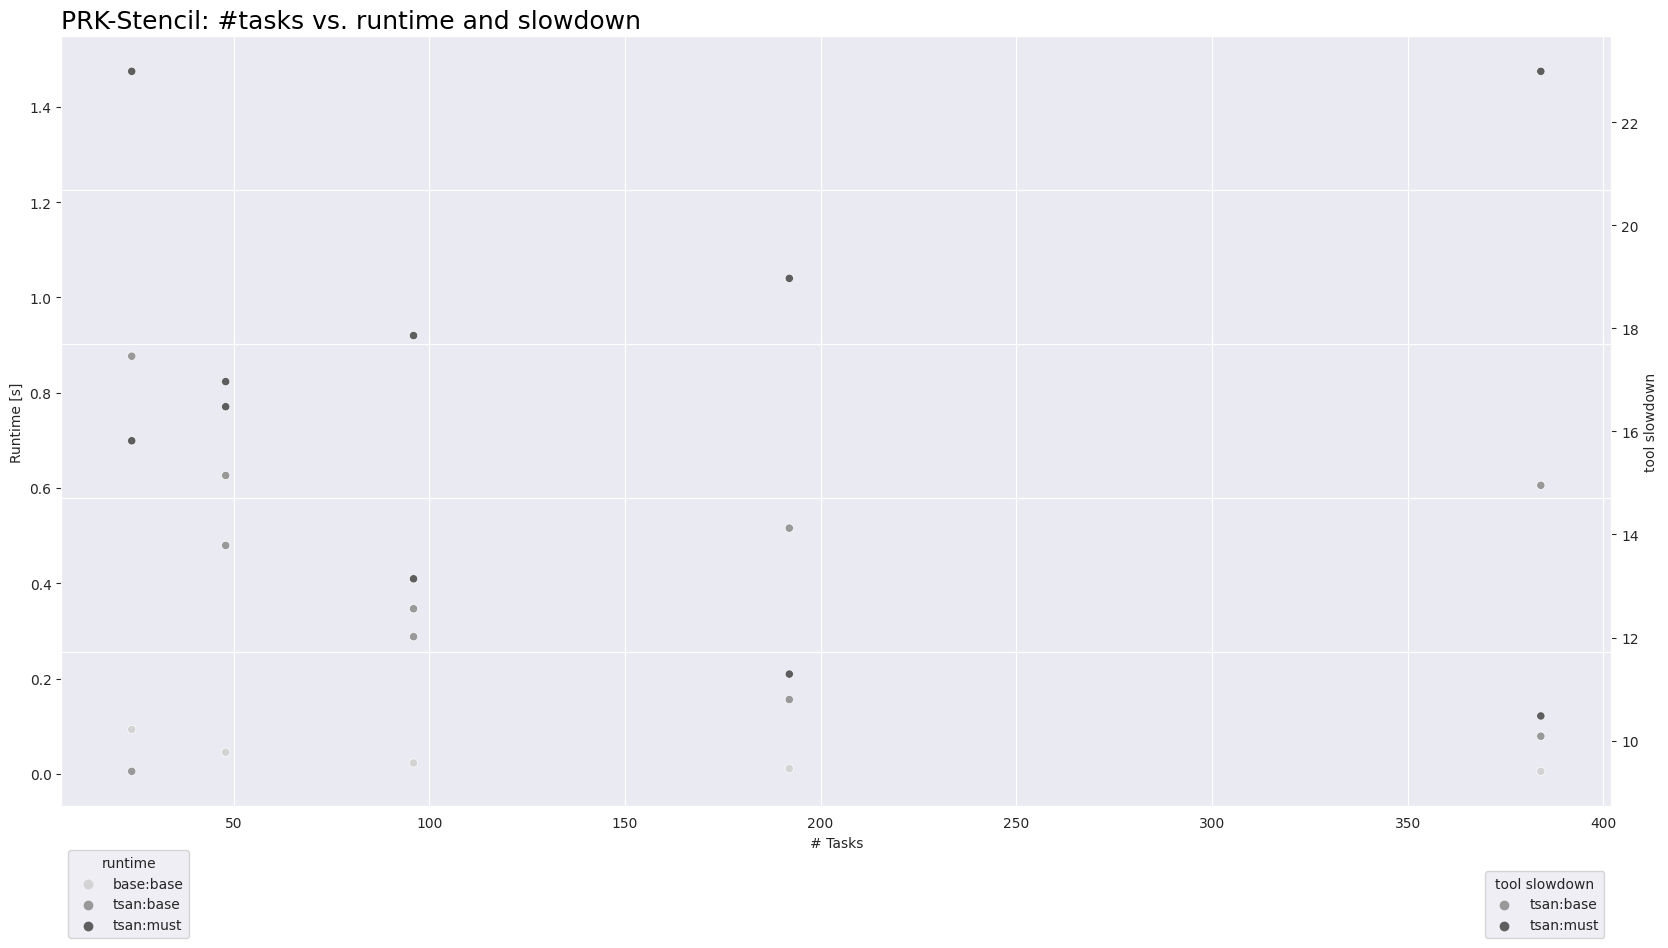

In [4]:
plot(runtime=scatterplot, slowdown=scatterplot)
plot(runtime=scatterplot, slowdown=scatterplot, palette=greyscale)

## Lineplot

<Figure size 640x480 with 0 Axes>

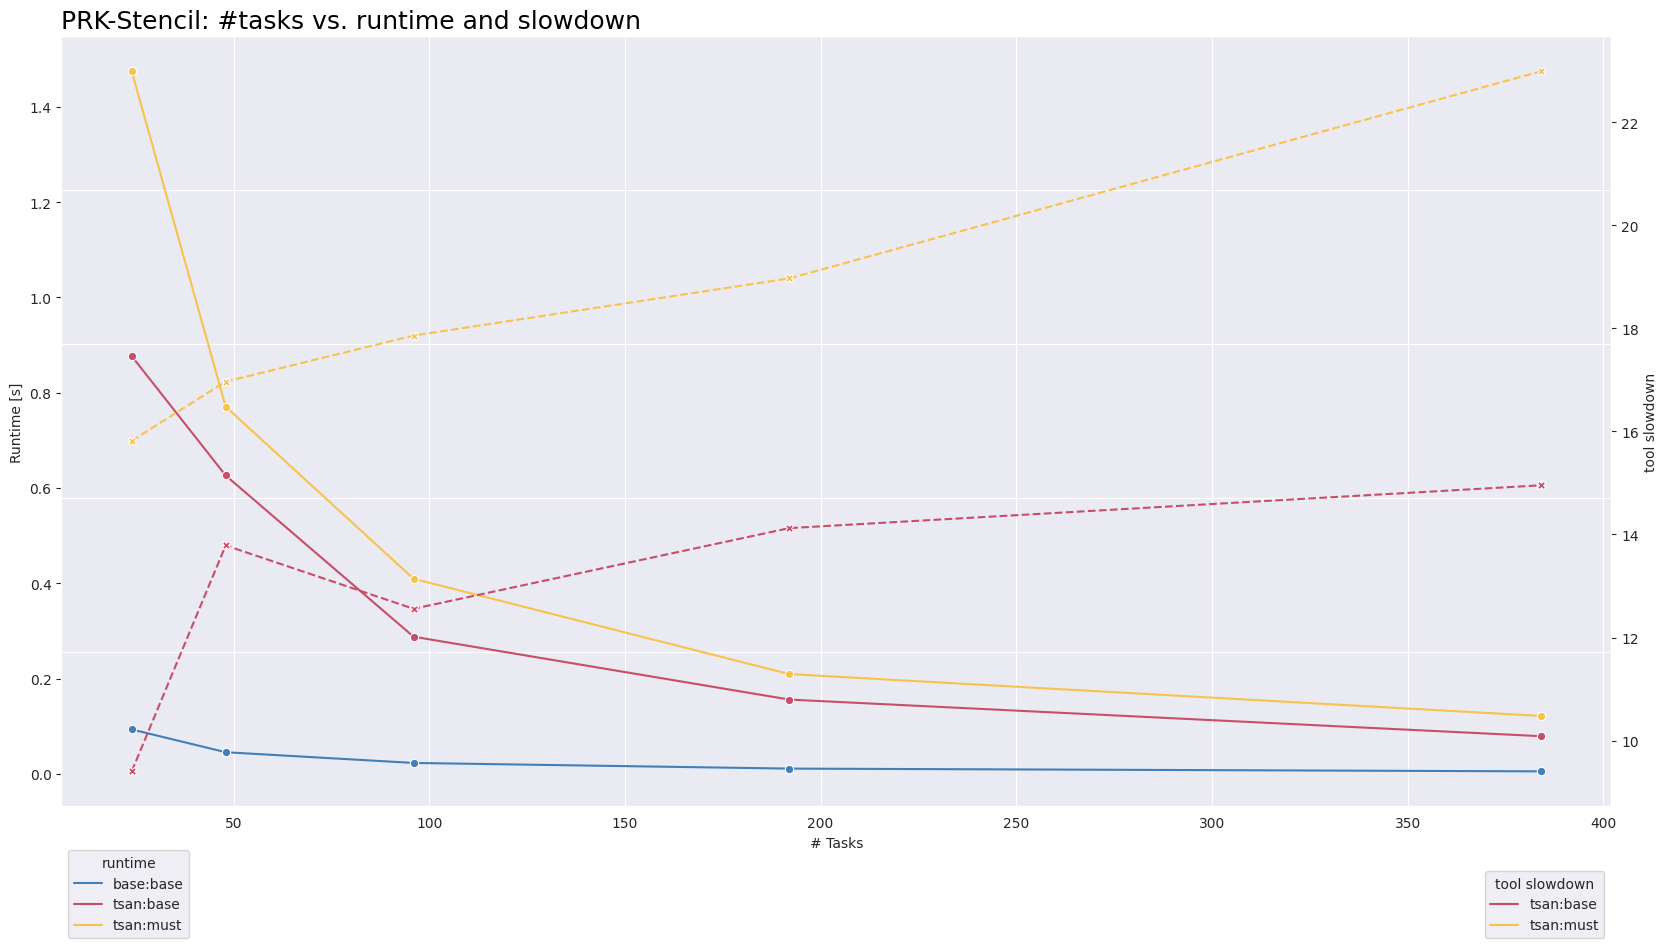

<Figure size 640x480 with 0 Axes>

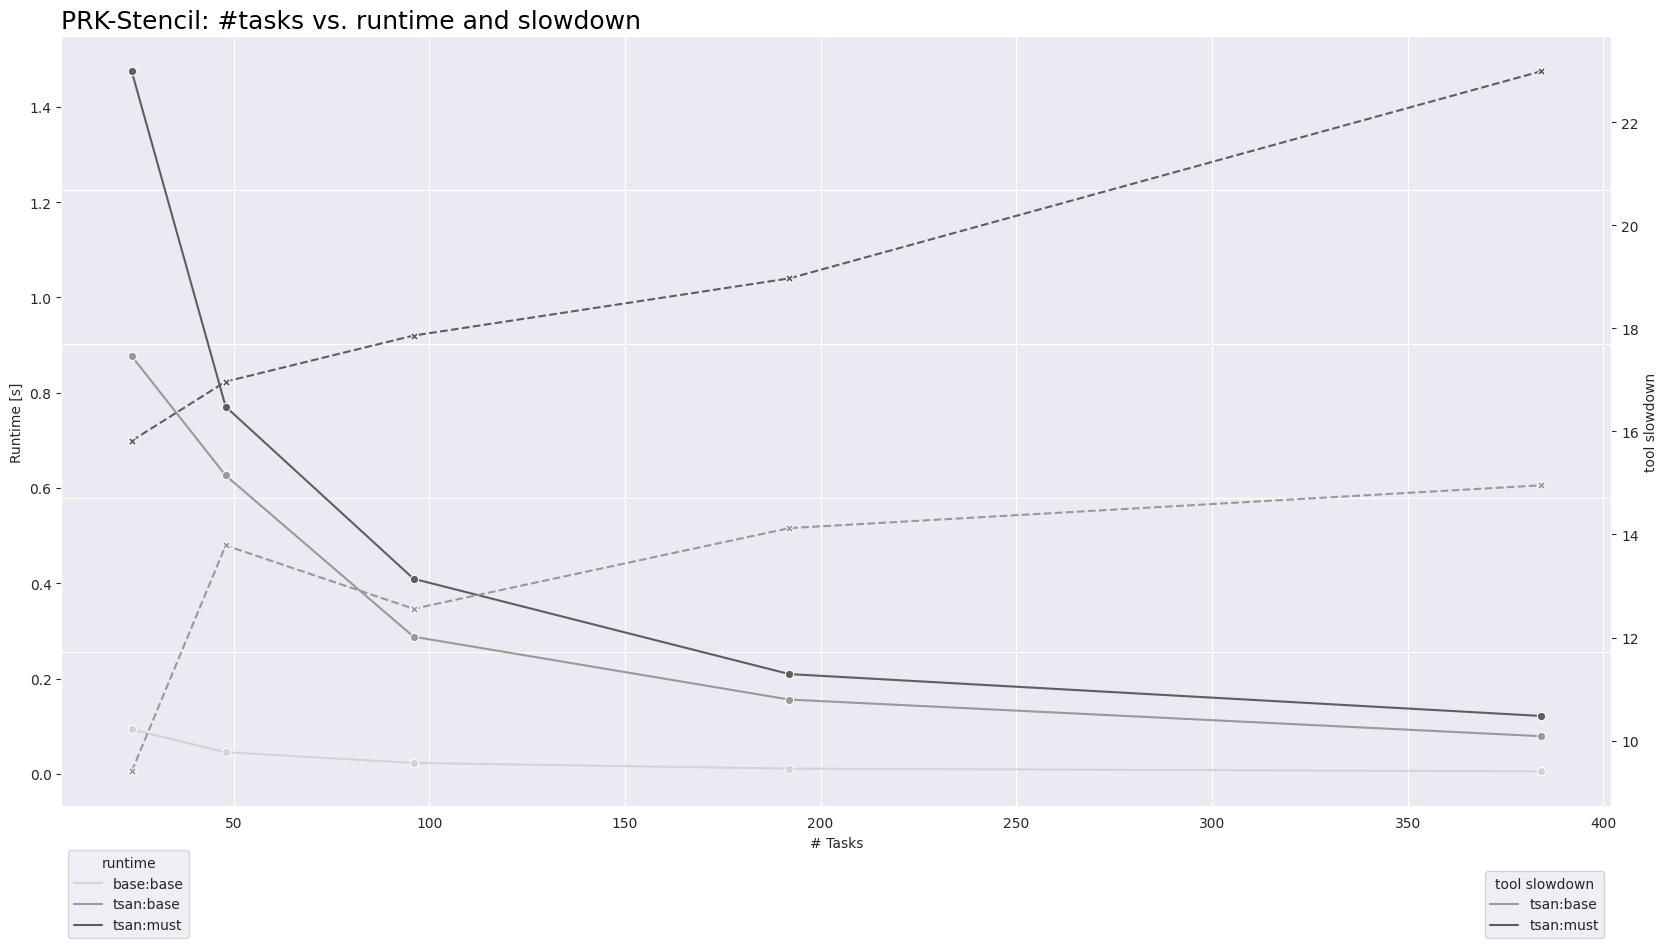

In [5]:
plot(runtime=lineplot, slowdown=lineplot, runtime_kwargs={"marker":"o"}, slowdown_kwargs={"marker":"X", "linestyle":"--"})
plot(runtime=lineplot, slowdown=lineplot, runtime_kwargs={"marker":"o"}, slowdown_kwargs={"marker":"X", "linestyle":"--"}, palette=greyscale)

# Categorical

## Pointplot without lines

<Figure size 640x480 with 0 Axes>

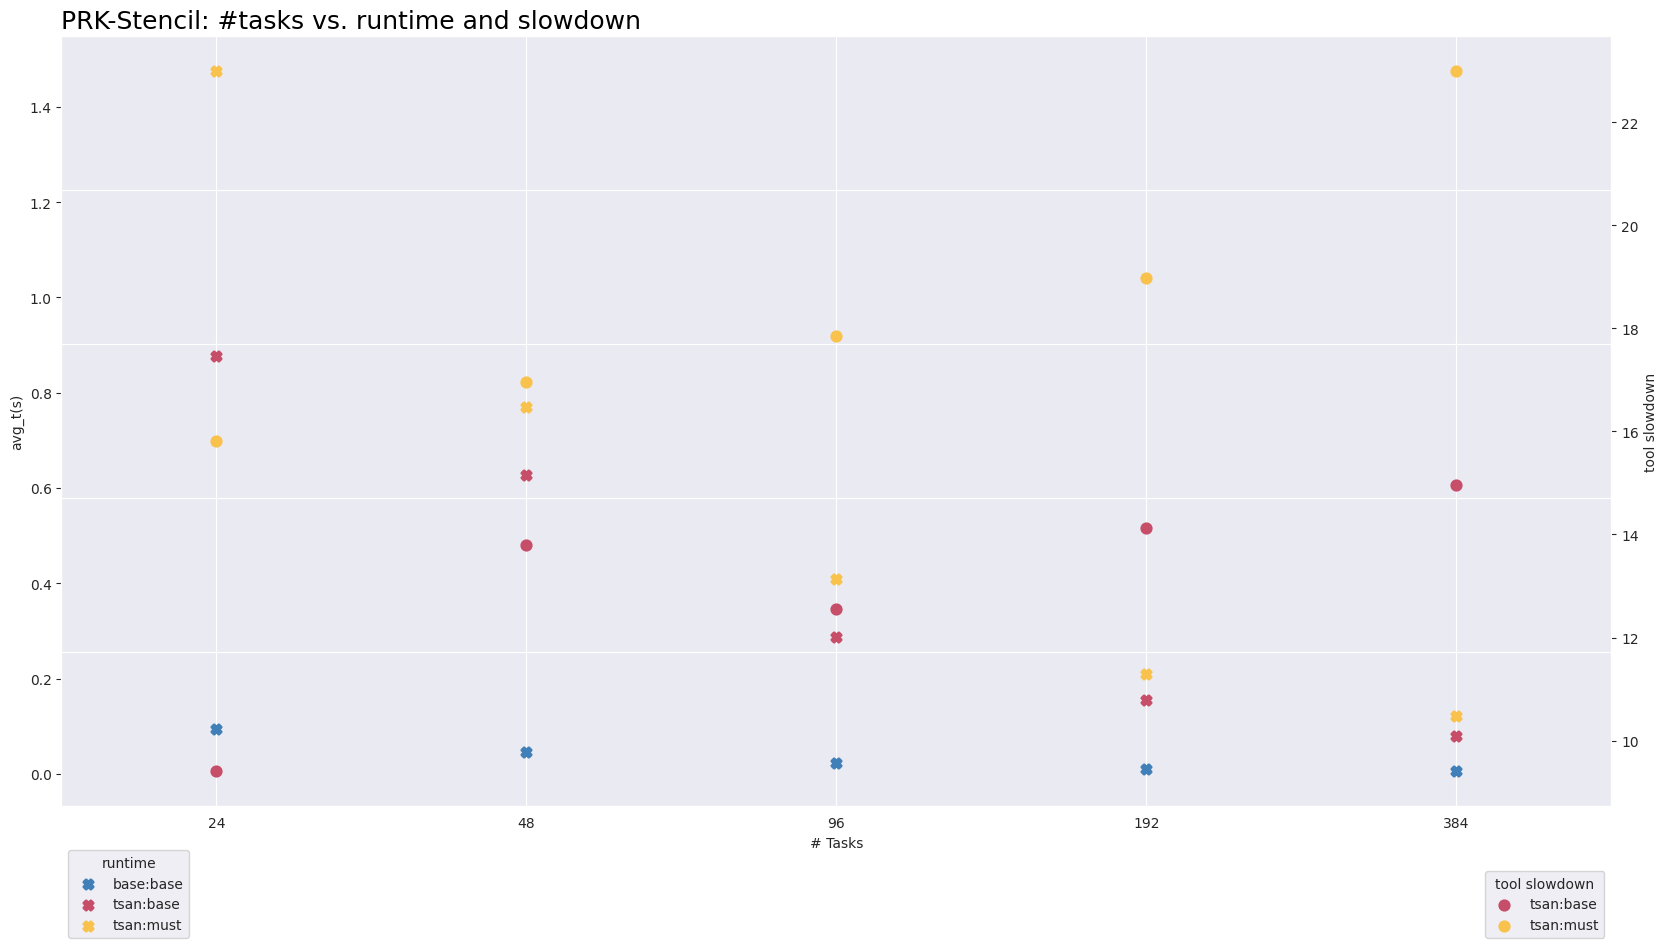

<Figure size 640x480 with 0 Axes>

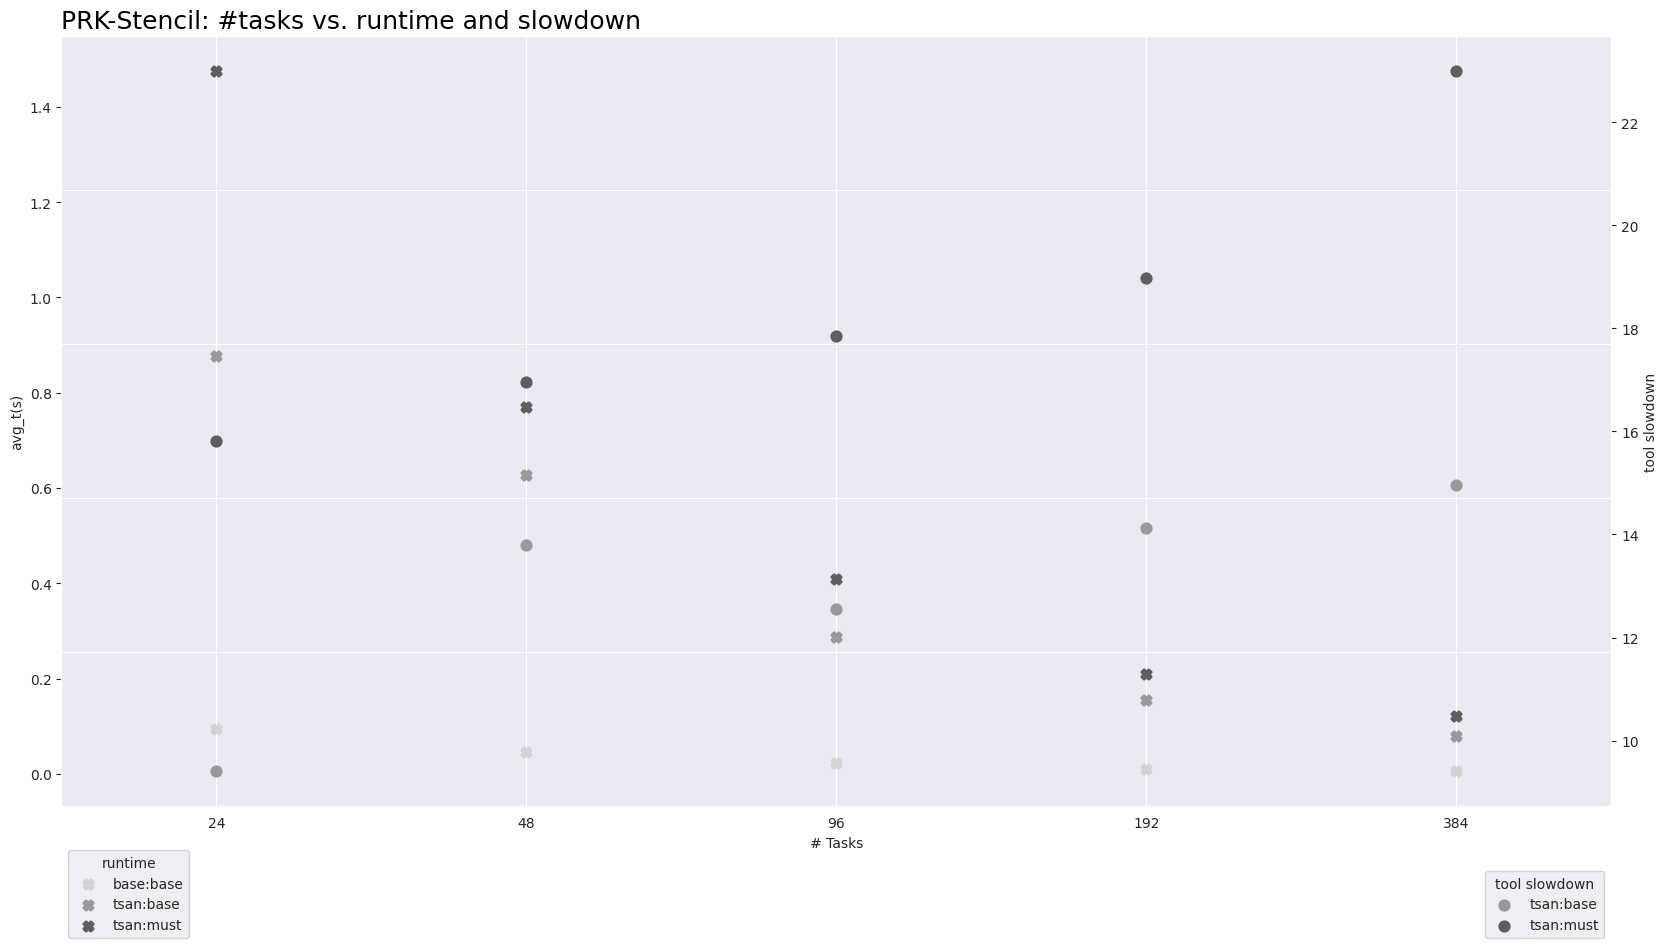

In [6]:
plot(runtime=pointplot, slowdown=pointplot, runtime_kwargs={"markers": "X"}, linestyles='', join=False)
plot(runtime=pointplot, slowdown=pointplot, runtime_kwargs={"markers": "X"}, palette=greyscale, linestyles='', join=False)

## Pointplot with lines

<Figure size 640x480 with 0 Axes>

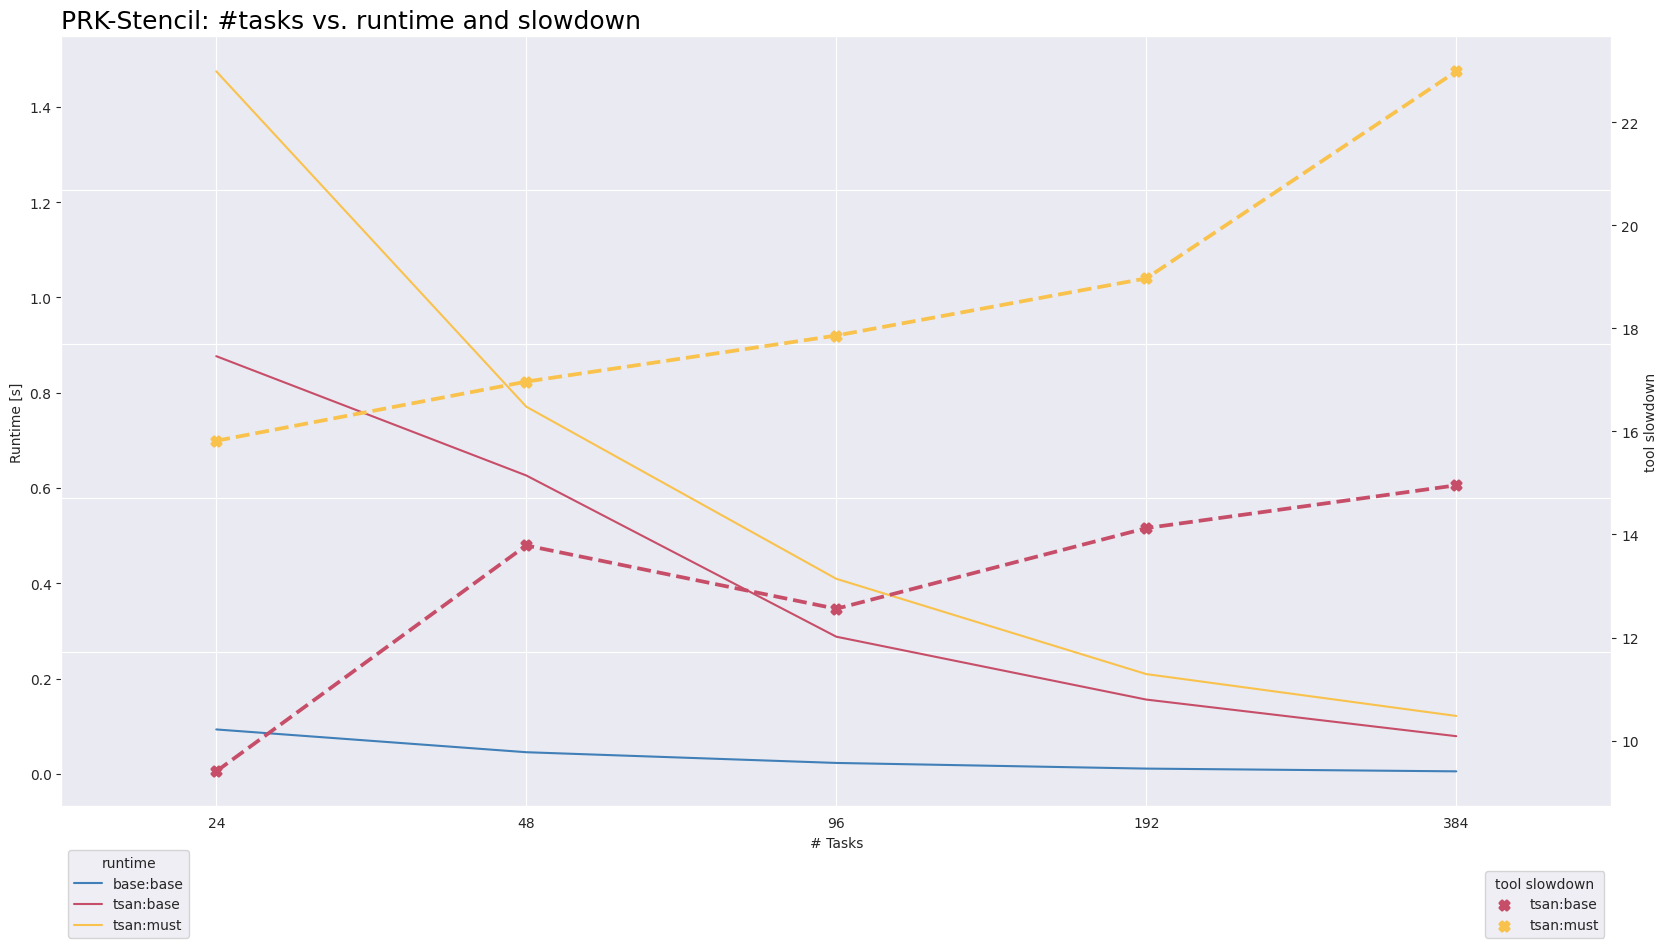

<Figure size 640x480 with 0 Axes>

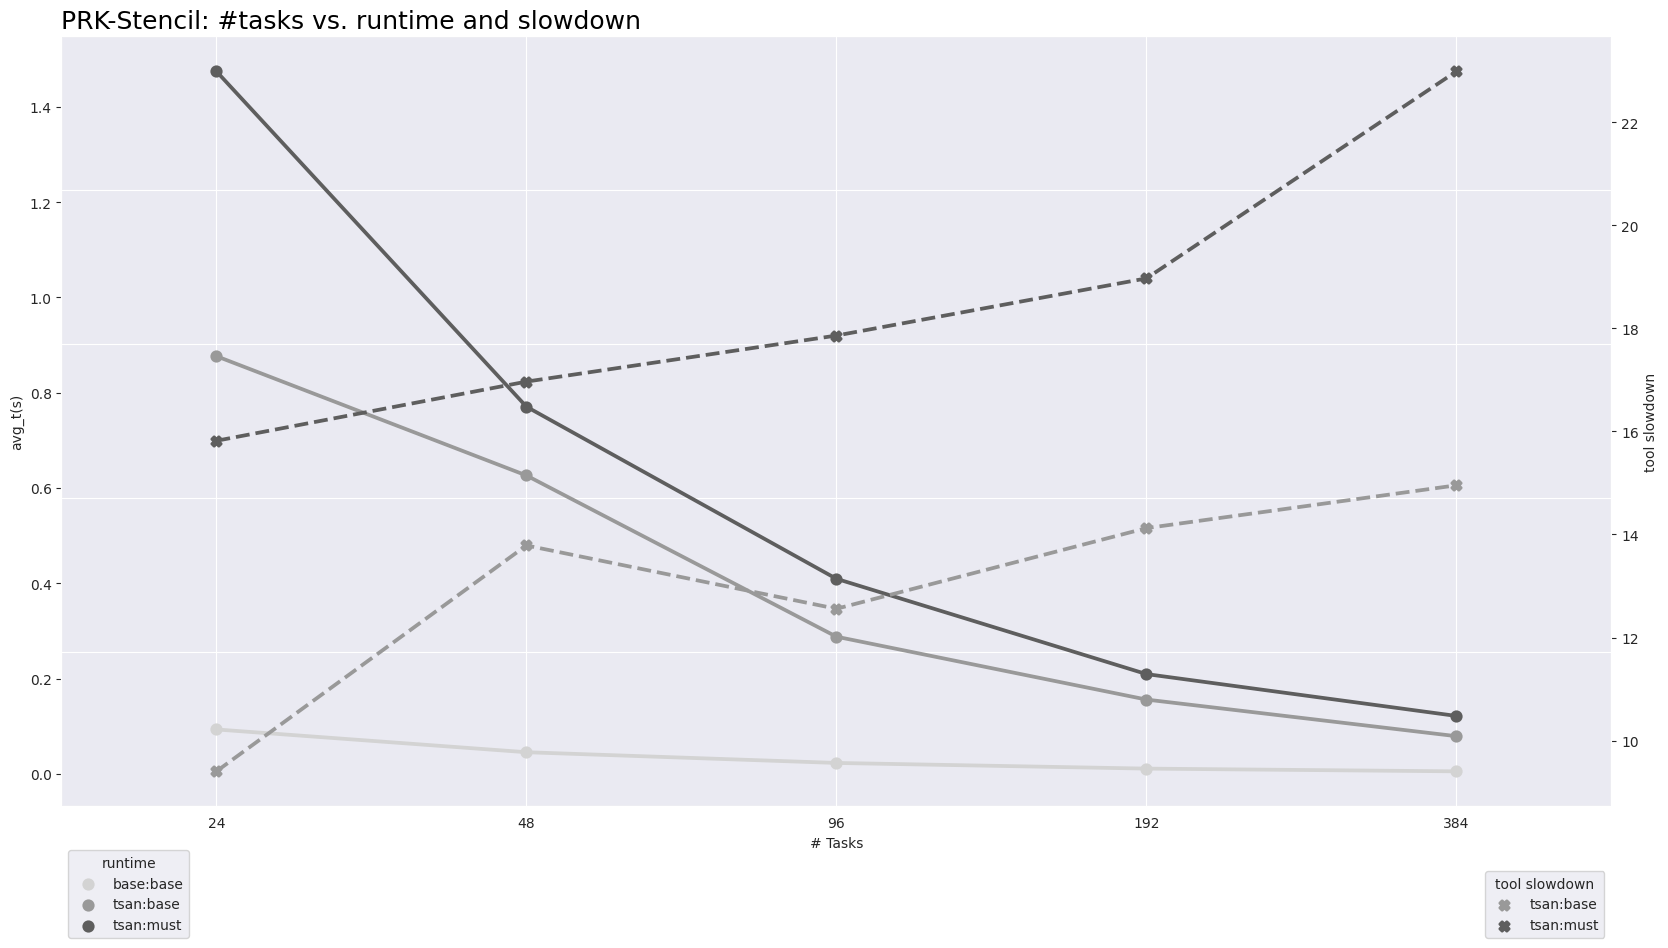

In [7]:
plot(runtime=cat_lineplot, slowdown=pointplot, slowdown_kwargs={"linestyles":"--", "markers":"X"})
plot(runtime=pointplot, slowdown=pointplot, slowdown_kwargs={"linestyles":"--", "markers":"X"}, palette=greyscale)

## Cat_lineplot (like pointplot but we use the lineplot function instead)
lineplot seems to have more styling options than pointplot

<Figure size 640x480 with 0 Axes>

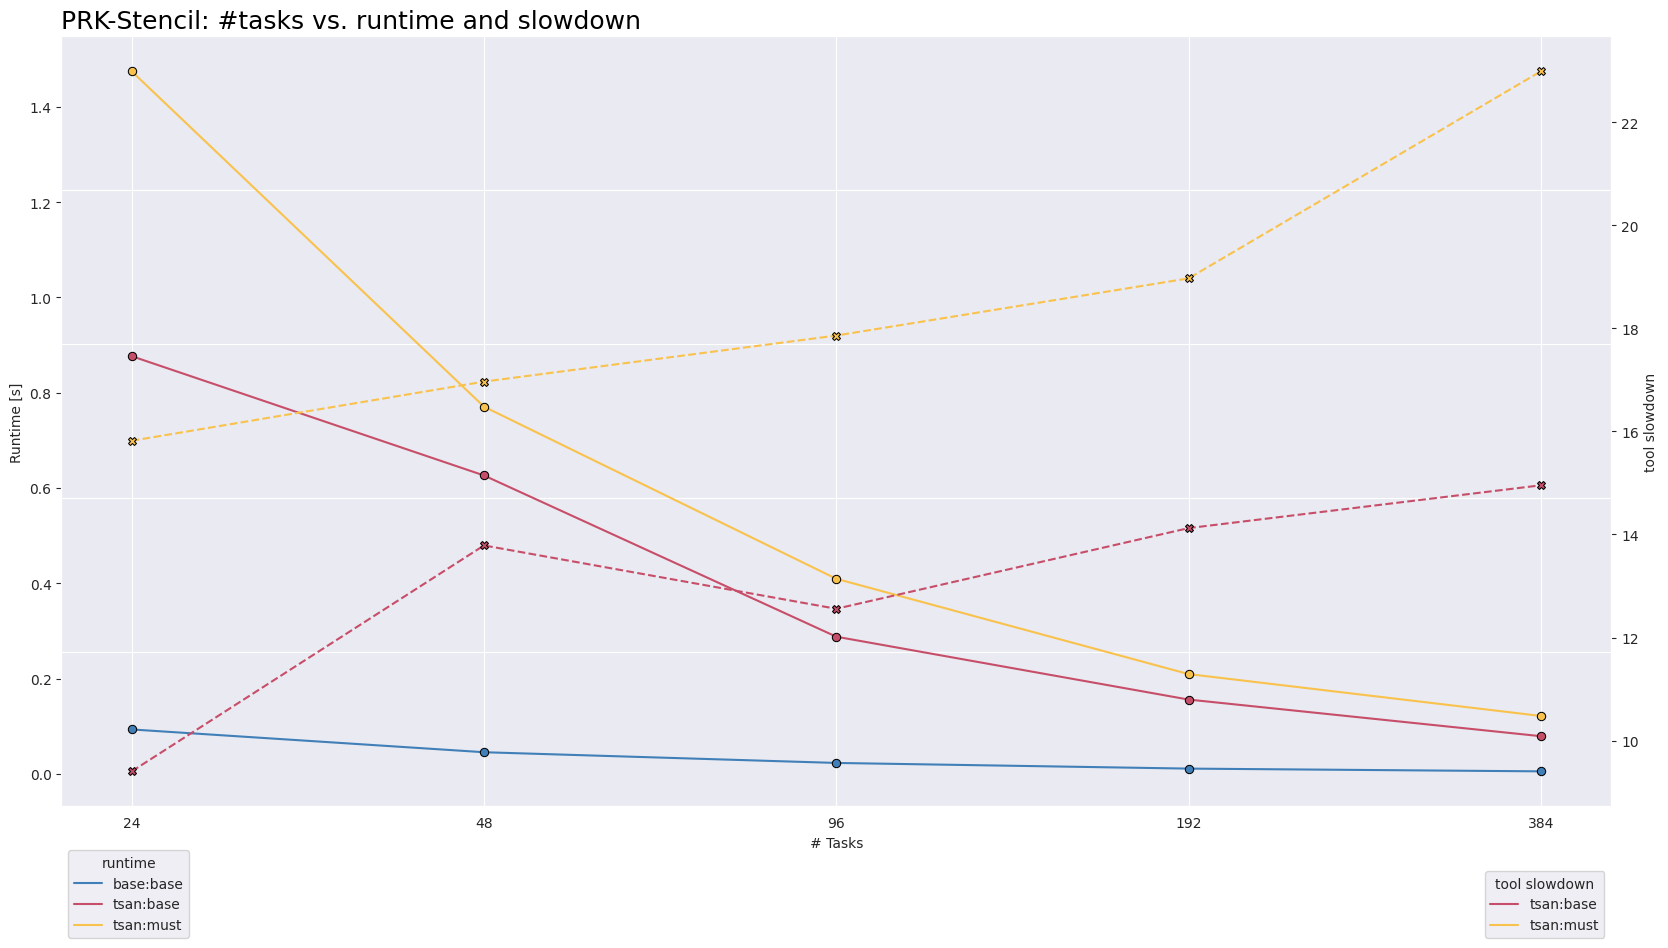

<Figure size 640x480 with 0 Axes>

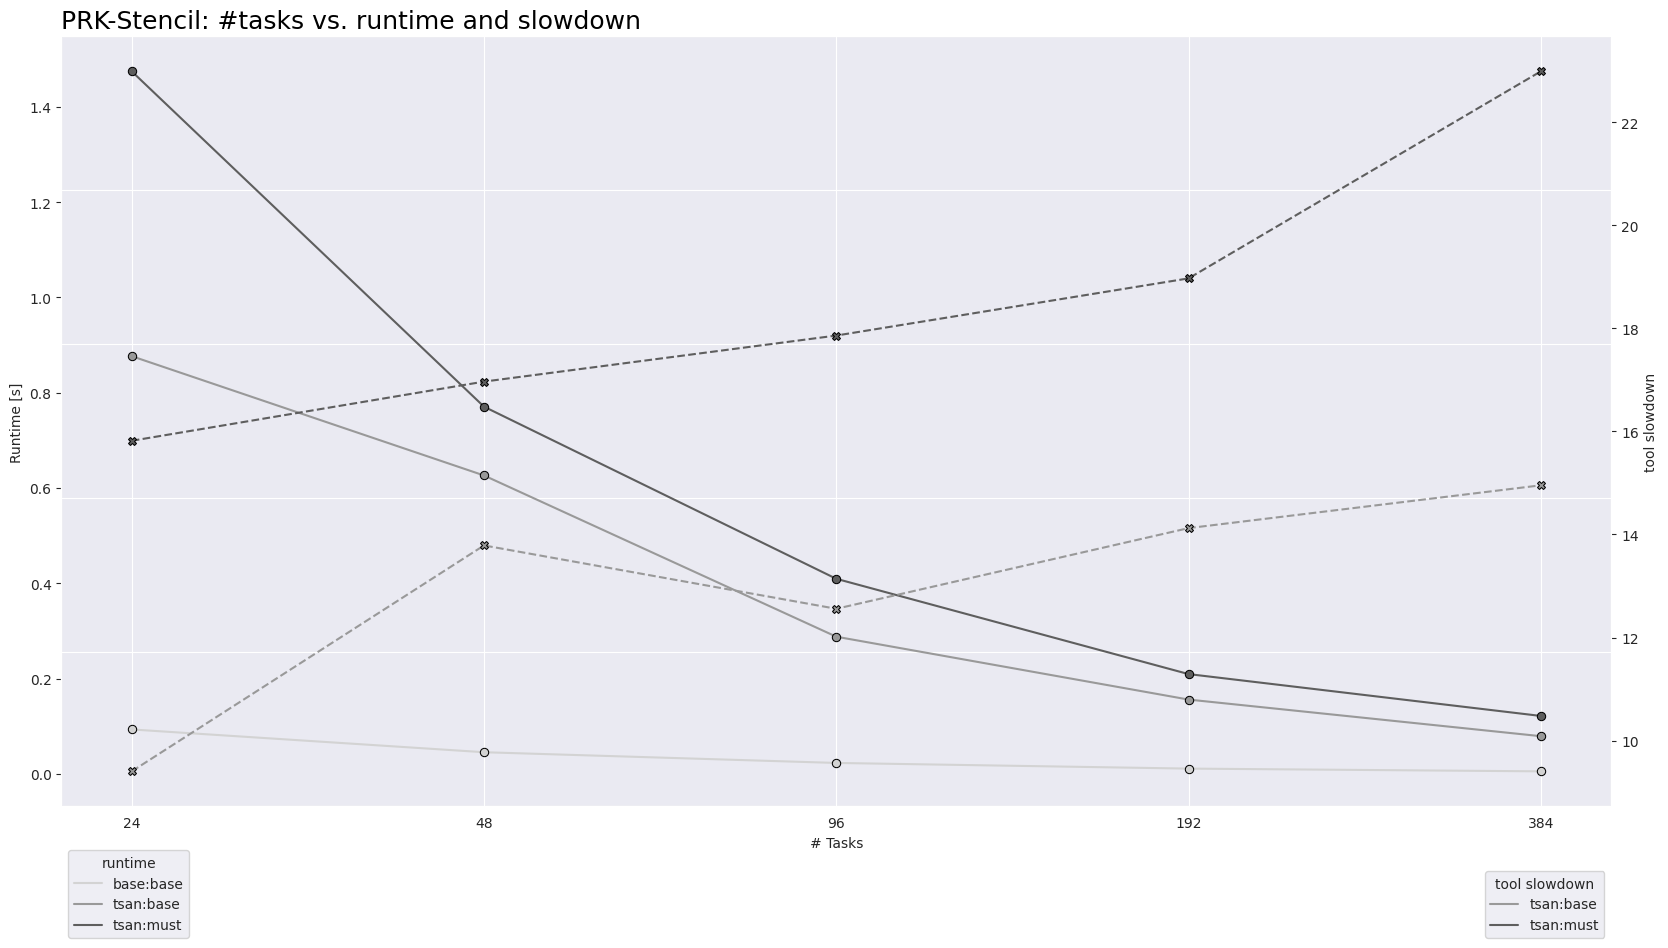

In [8]:
plot(runtime=cat_lineplot, slowdown=cat_lineplot, runtime_kwargs={"marker":"o", "markeredgecolor": "black"}, slowdown_kwargs={"marker":"X", "linestyle":"--", "markeredgecolor": "black"})
plot(runtime=cat_lineplot, slowdown=cat_lineplot, runtime_kwargs={"marker":"o", "markeredgecolor": "black"}, slowdown_kwargs={"marker":"X", "linestyle":"--", "markeredgecolor": "black"}, palette=greyscale)

## Grouped Barchart with pointplot

<Figure size 640x480 with 0 Axes>

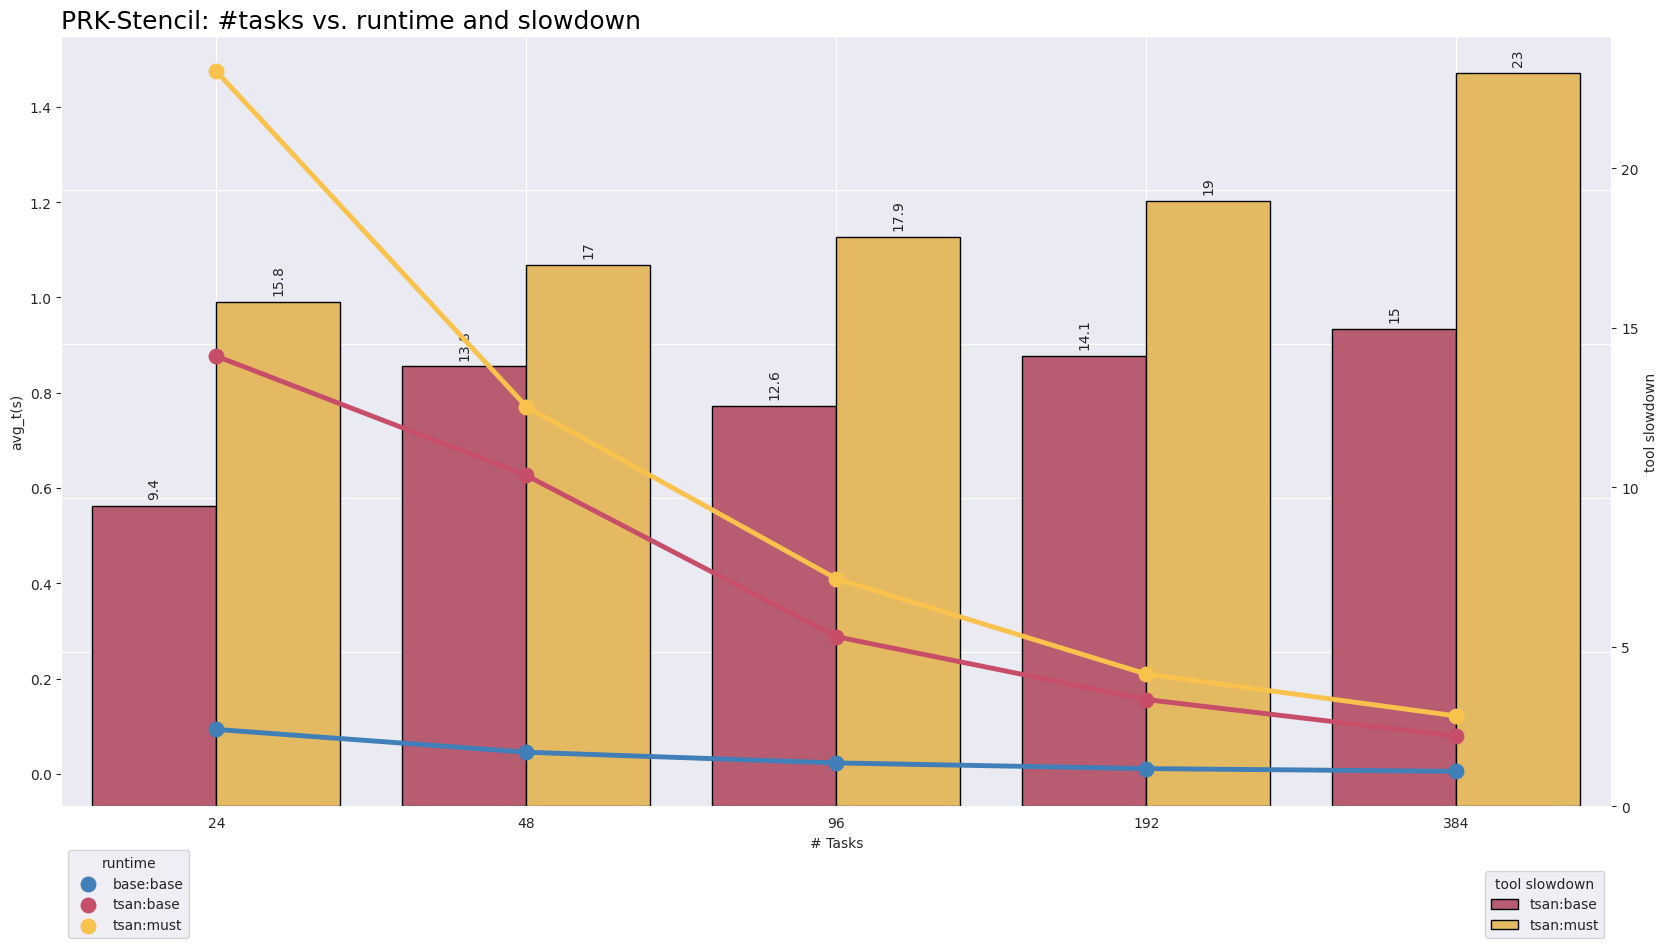

<Figure size 640x480 with 0 Axes>

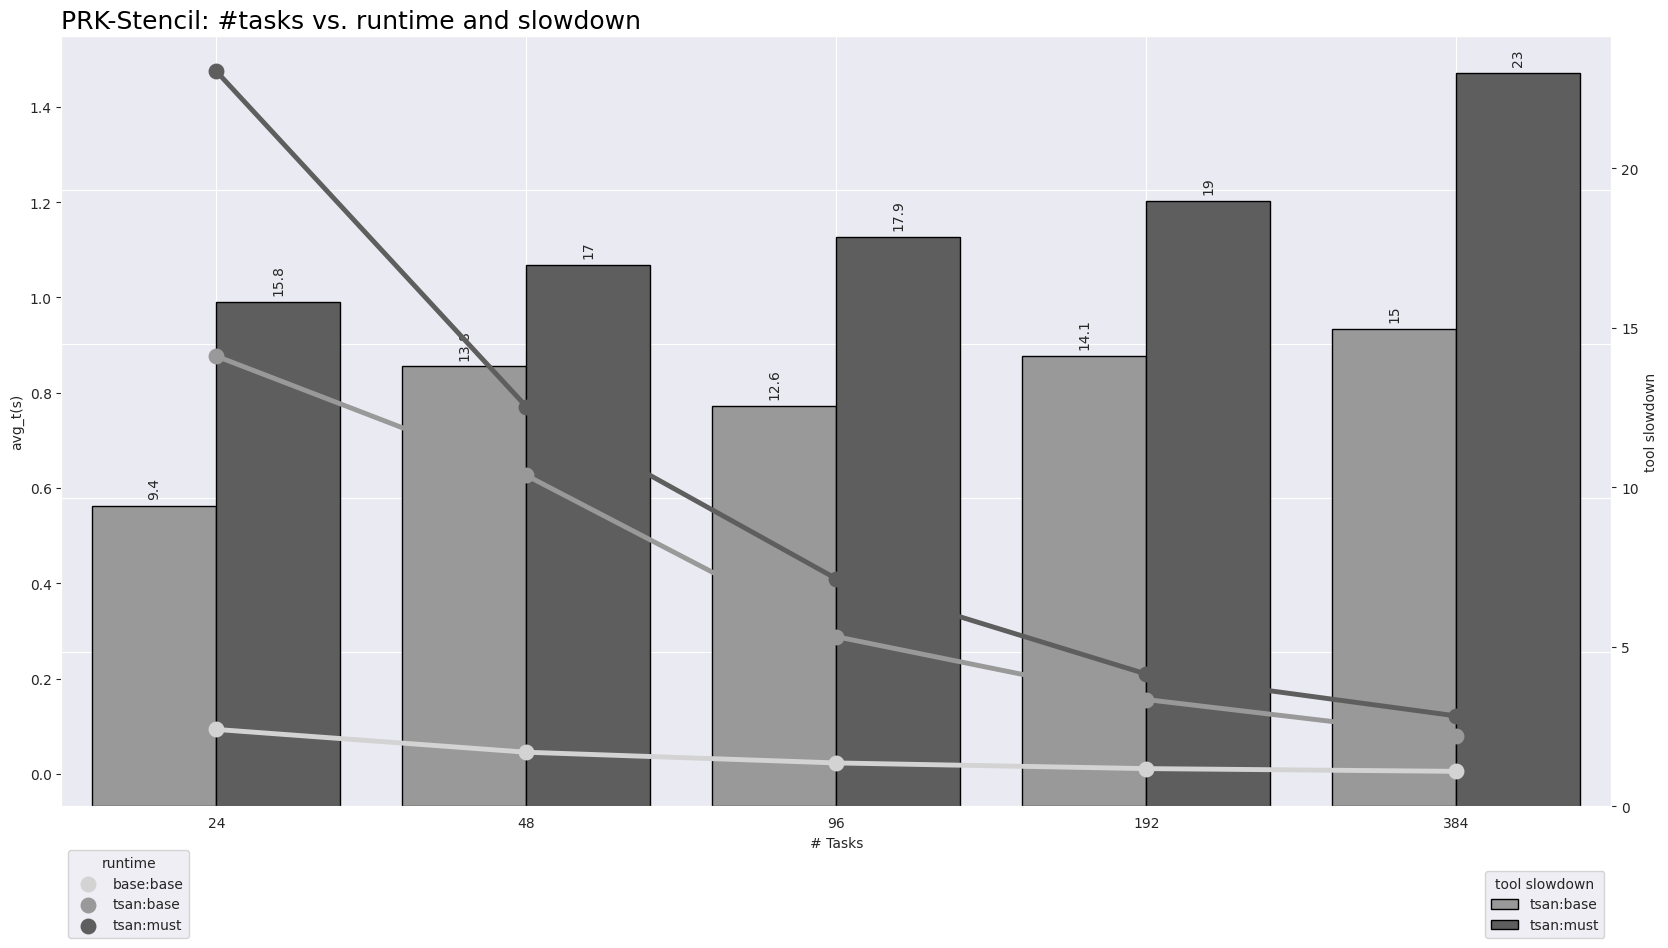

In [9]:
plot(runtime=pointplot, slowdown=grouped_barplot, primary="slowdown", edgecolor="black", runtime_kwargs={"scale":1.3})
plot(runtime=pointplot, slowdown=grouped_barplot, primary="slowdown", palette=greyscale, edgecolor="black", runtime_kwargs={"scale":1.3})

## Grouped Barchart with cat_lineplot

<Figure size 640x480 with 0 Axes>

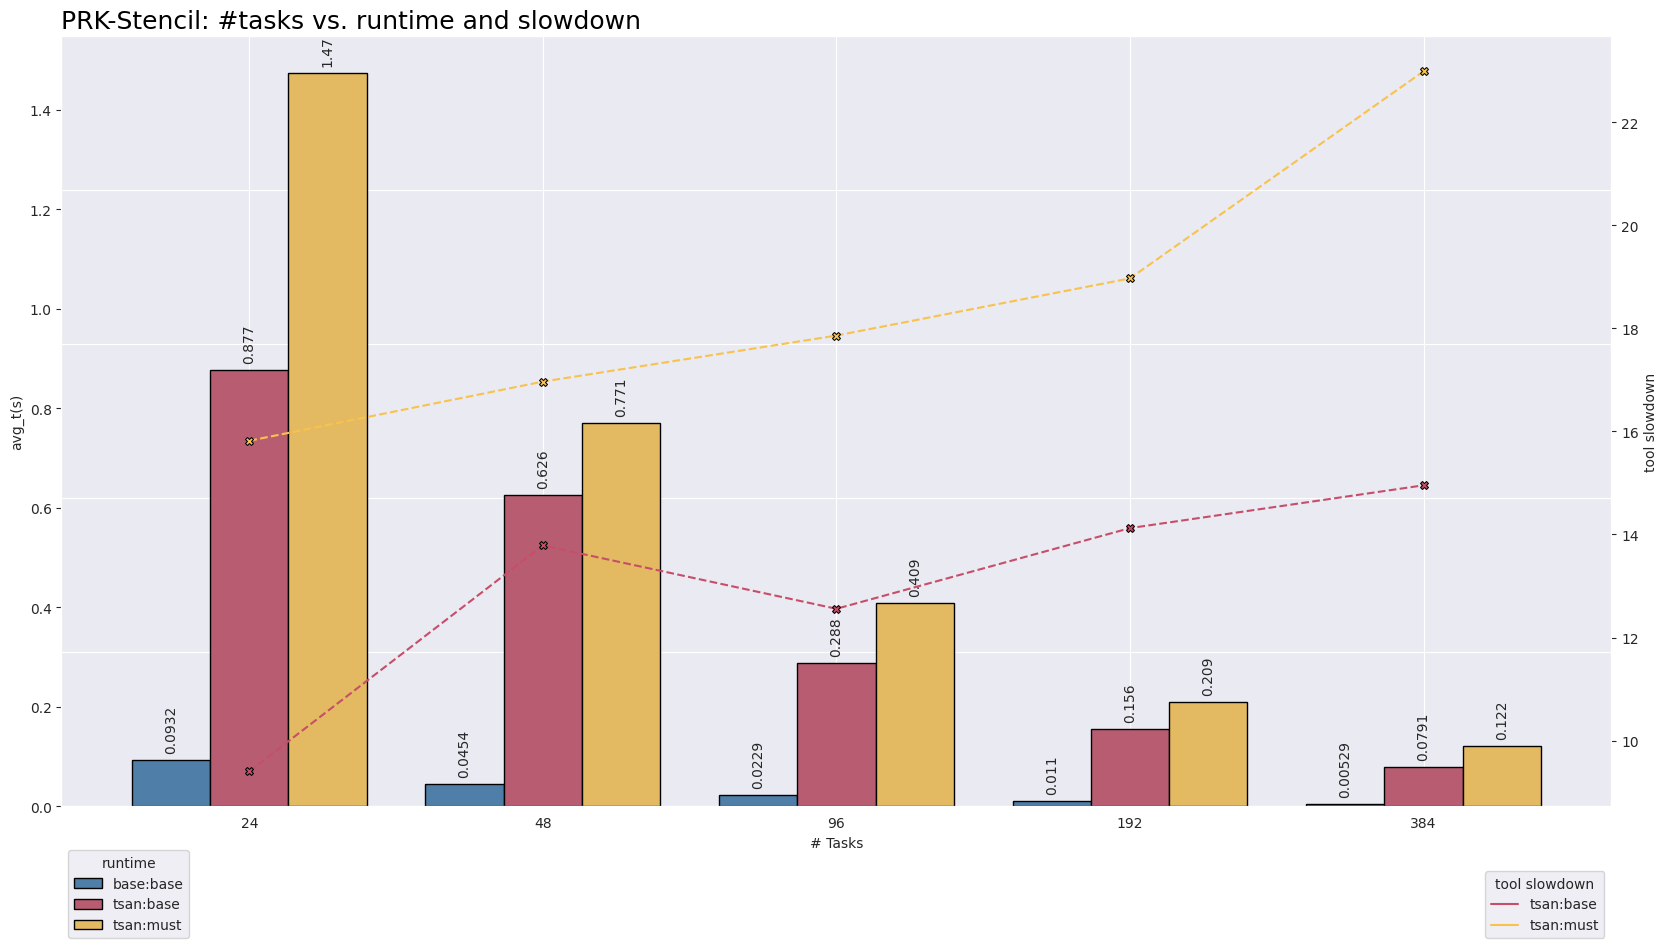

<Figure size 640x480 with 0 Axes>

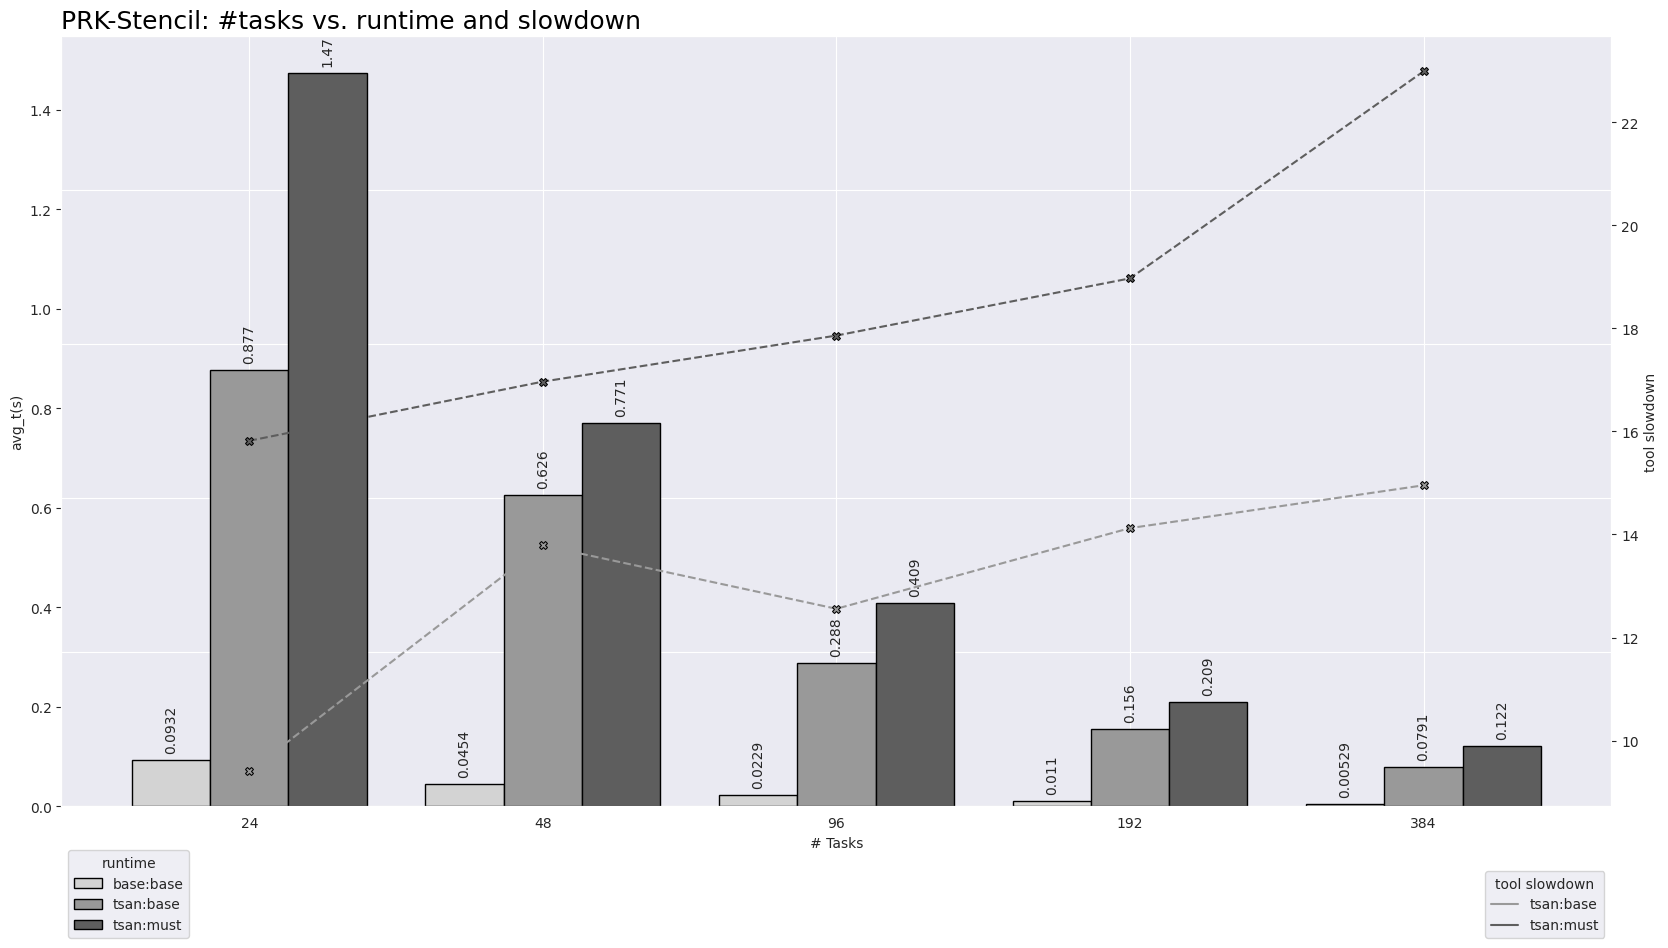

In [10]:
plot(runtime=grouped_barplot, slowdown=cat_lineplot, runtime_kwargs={"edgecolor":"black"}, slowdown_kwargs={"marker":"X", "linestyle":"--", "markeredgecolor": "black"})
plot(runtime=grouped_barplot, slowdown=cat_lineplot, runtime_kwargs={"edgecolor":"black"}, slowdown_kwargs={"marker":"X", "linestyle":"--", "markeredgecolor": "black"}, palette=greyscale)

## Overlayed Barchart with pointplot

<Figure size 640x480 with 0 Axes>

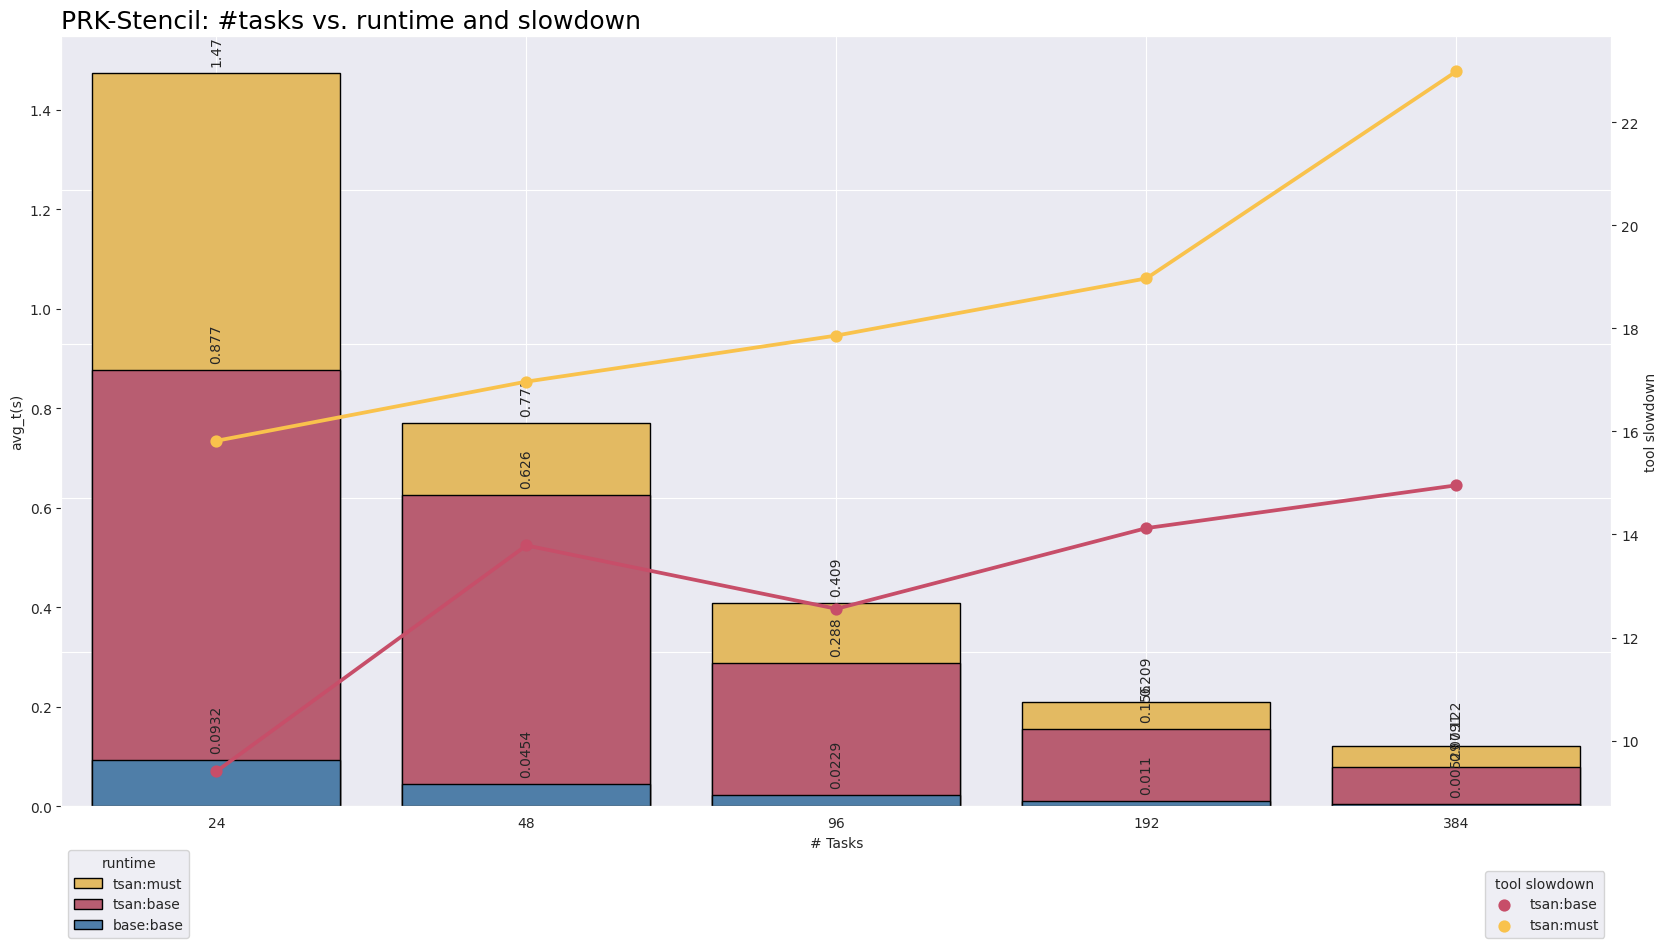

<Figure size 640x480 with 0 Axes>

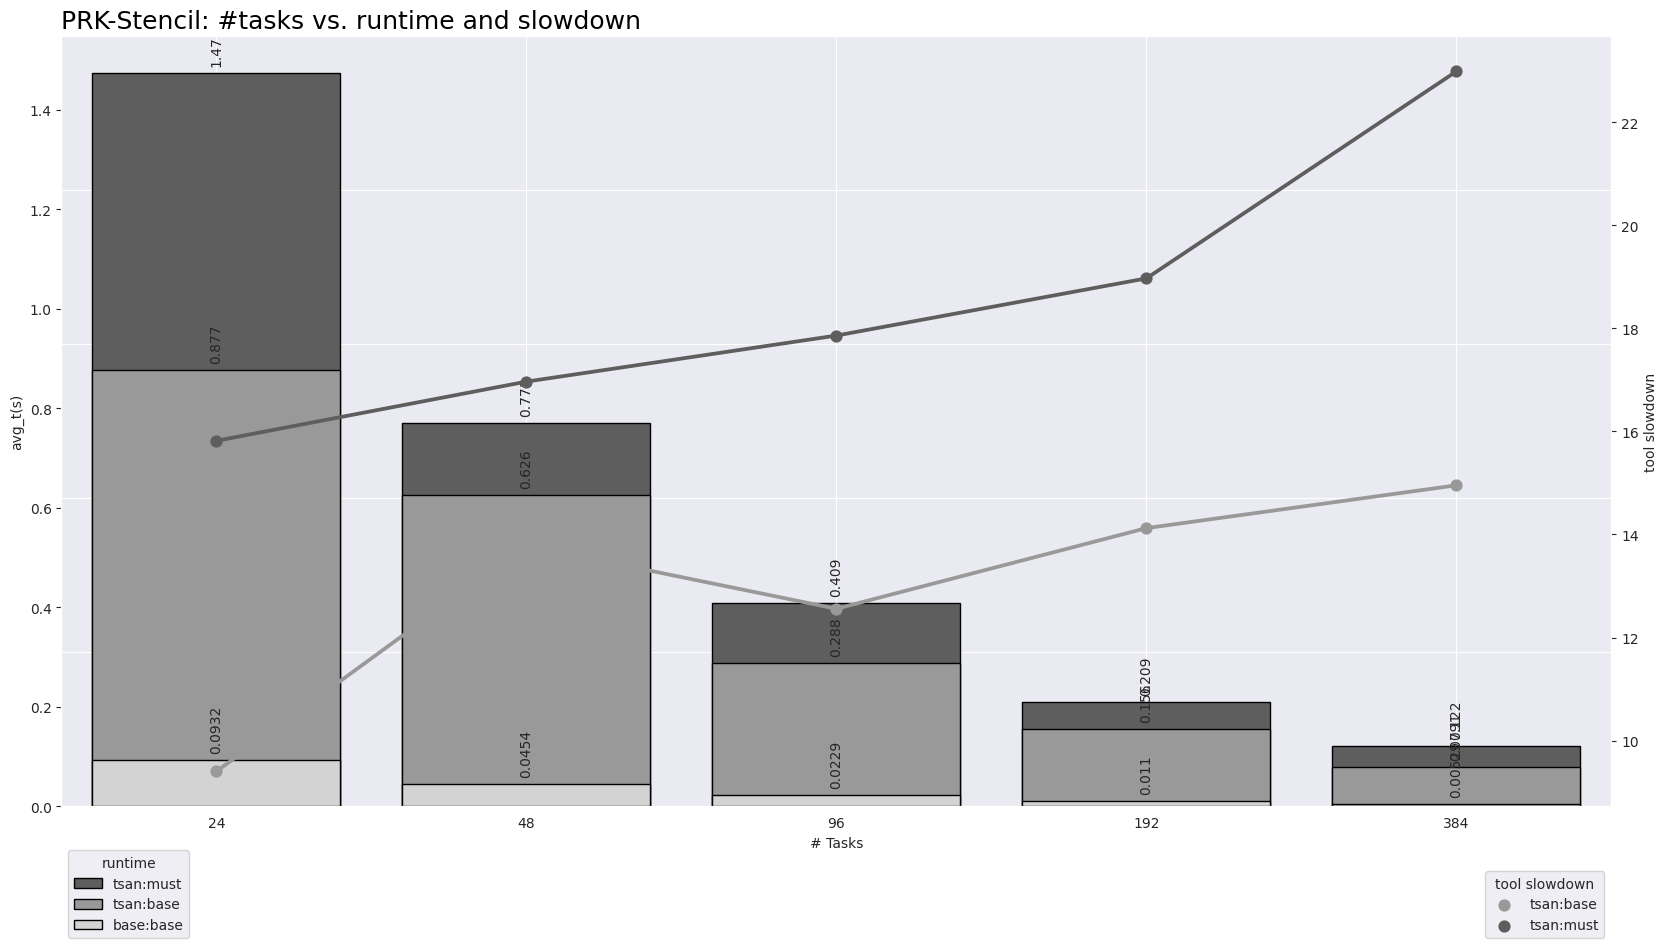

In [11]:
plot(runtime=overlapping_barplot, slowdown=pointplot, edgecolor="black")
plot(runtime=overlapping_barplot, slowdown=pointplot, palette=greyscale, edgecolor="black")

### Slowdown plotted as bars

<Figure size 640x480 with 0 Axes>

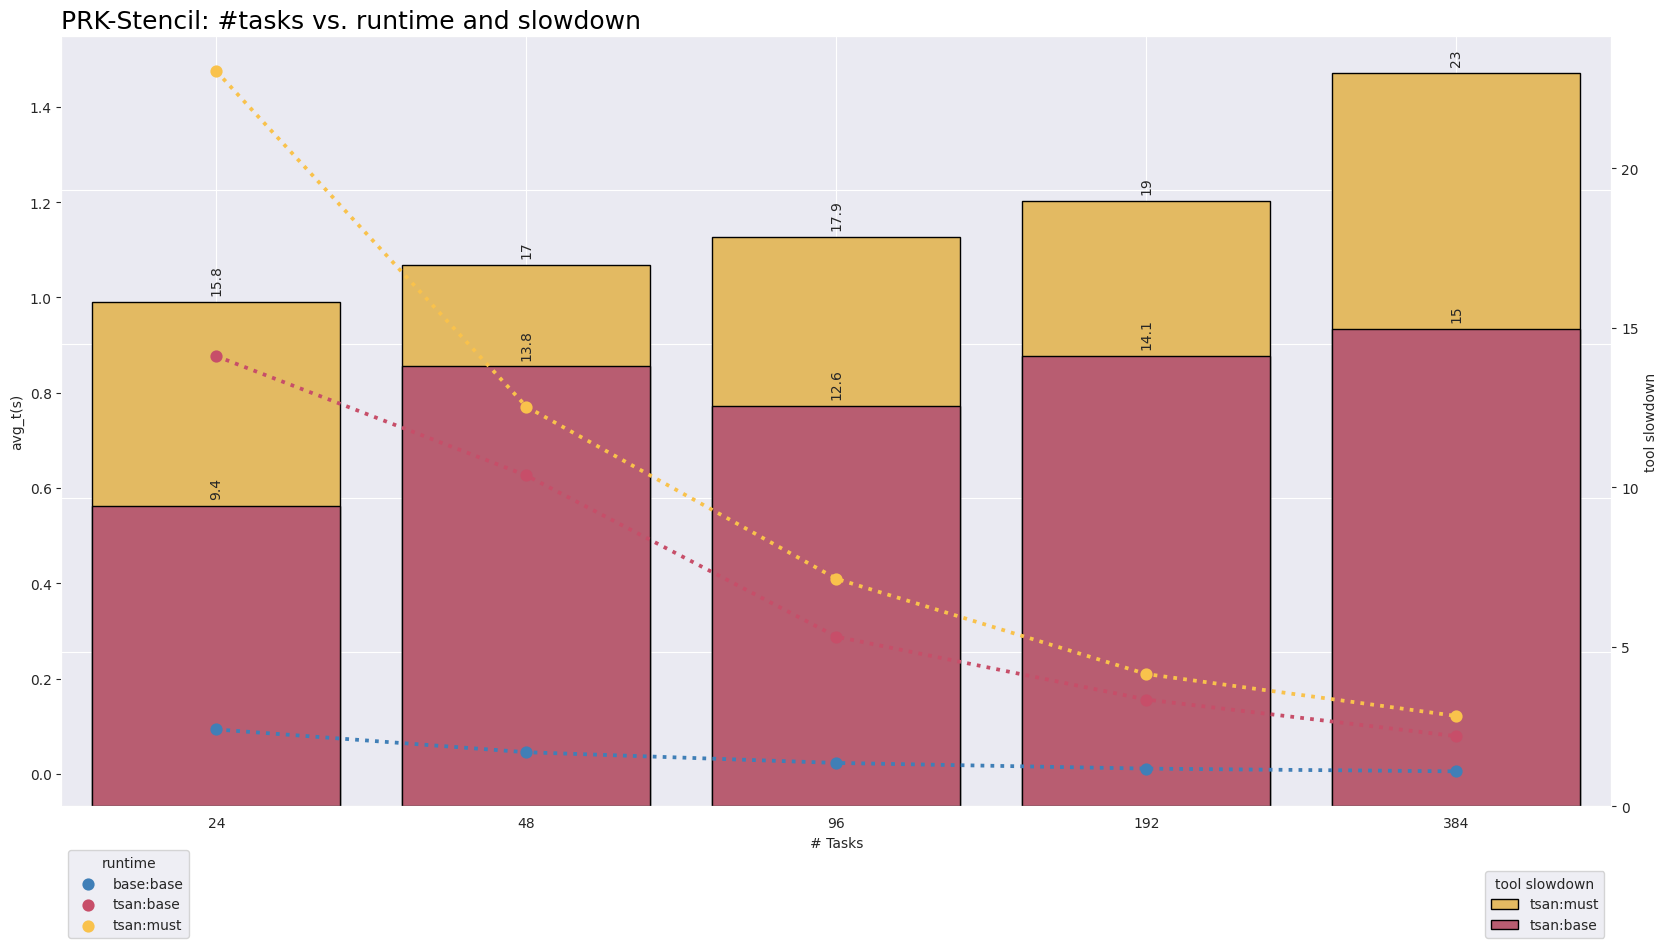

<Figure size 640x480 with 0 Axes>

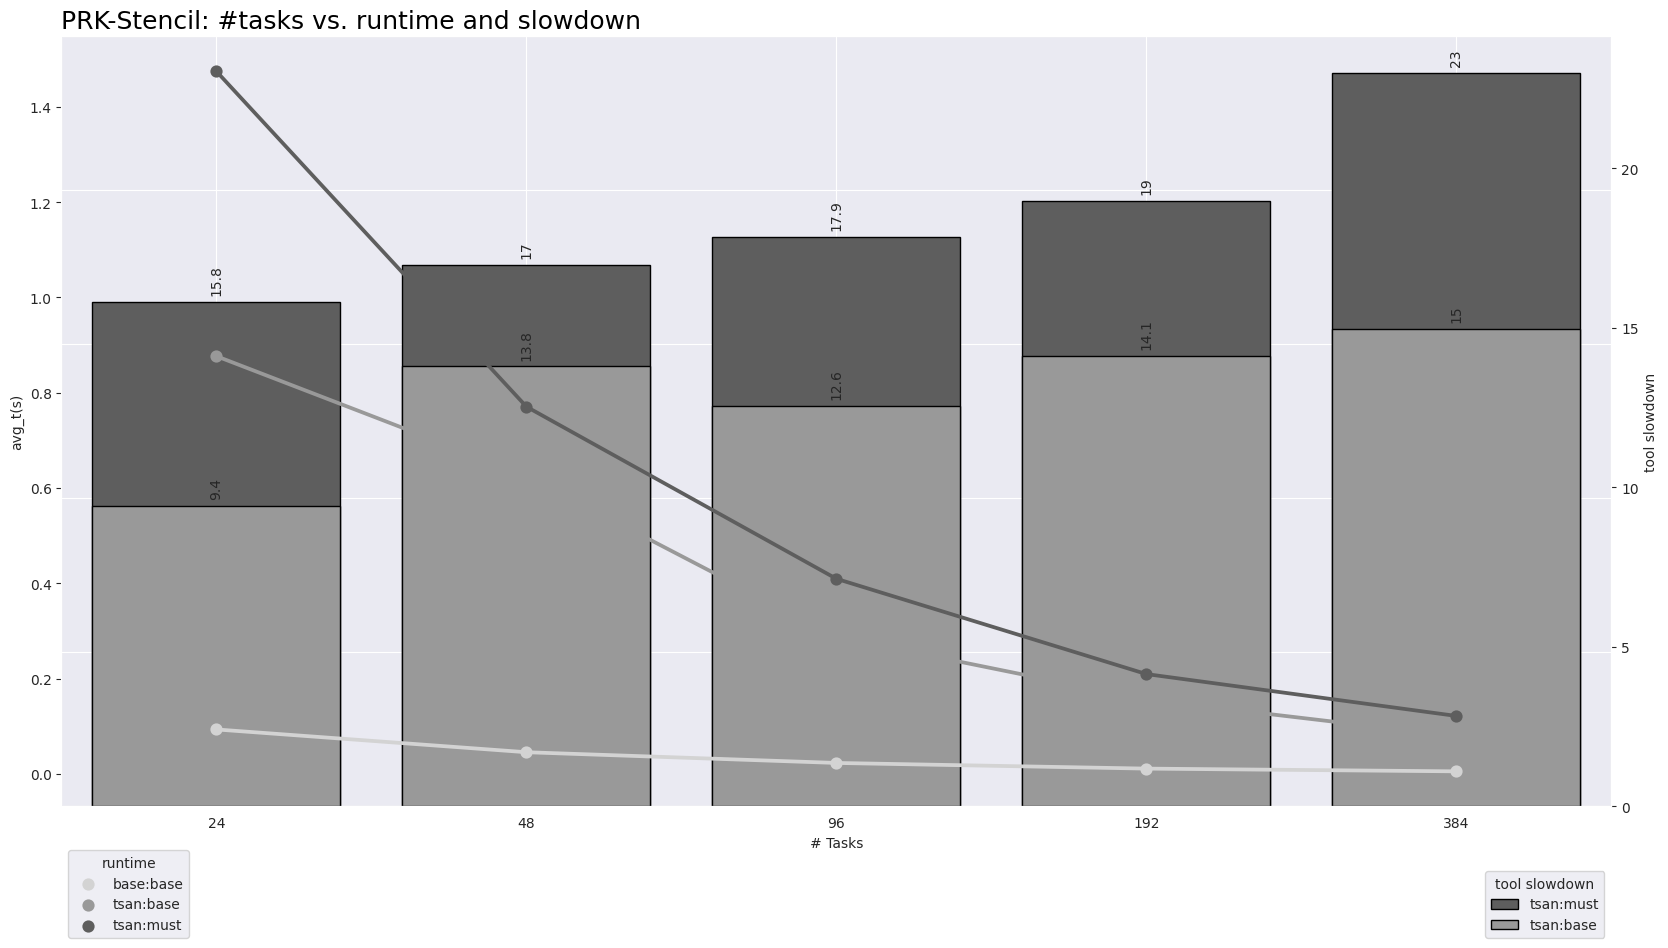

In [12]:
plot(runtime=pointplot, slowdown=overlapping_barplot, primary="slowdown", edgecolor="black", runtime_kwargs={"linestyles":":", "alpha":0.2})
plot(runtime=pointplot, slowdown=overlapping_barplot, primary="slowdown", palette=greyscale, edgecolor="black")

## Overlayed Barchart with cat_lineplot and path effects

<Figure size 640x480 with 0 Axes>

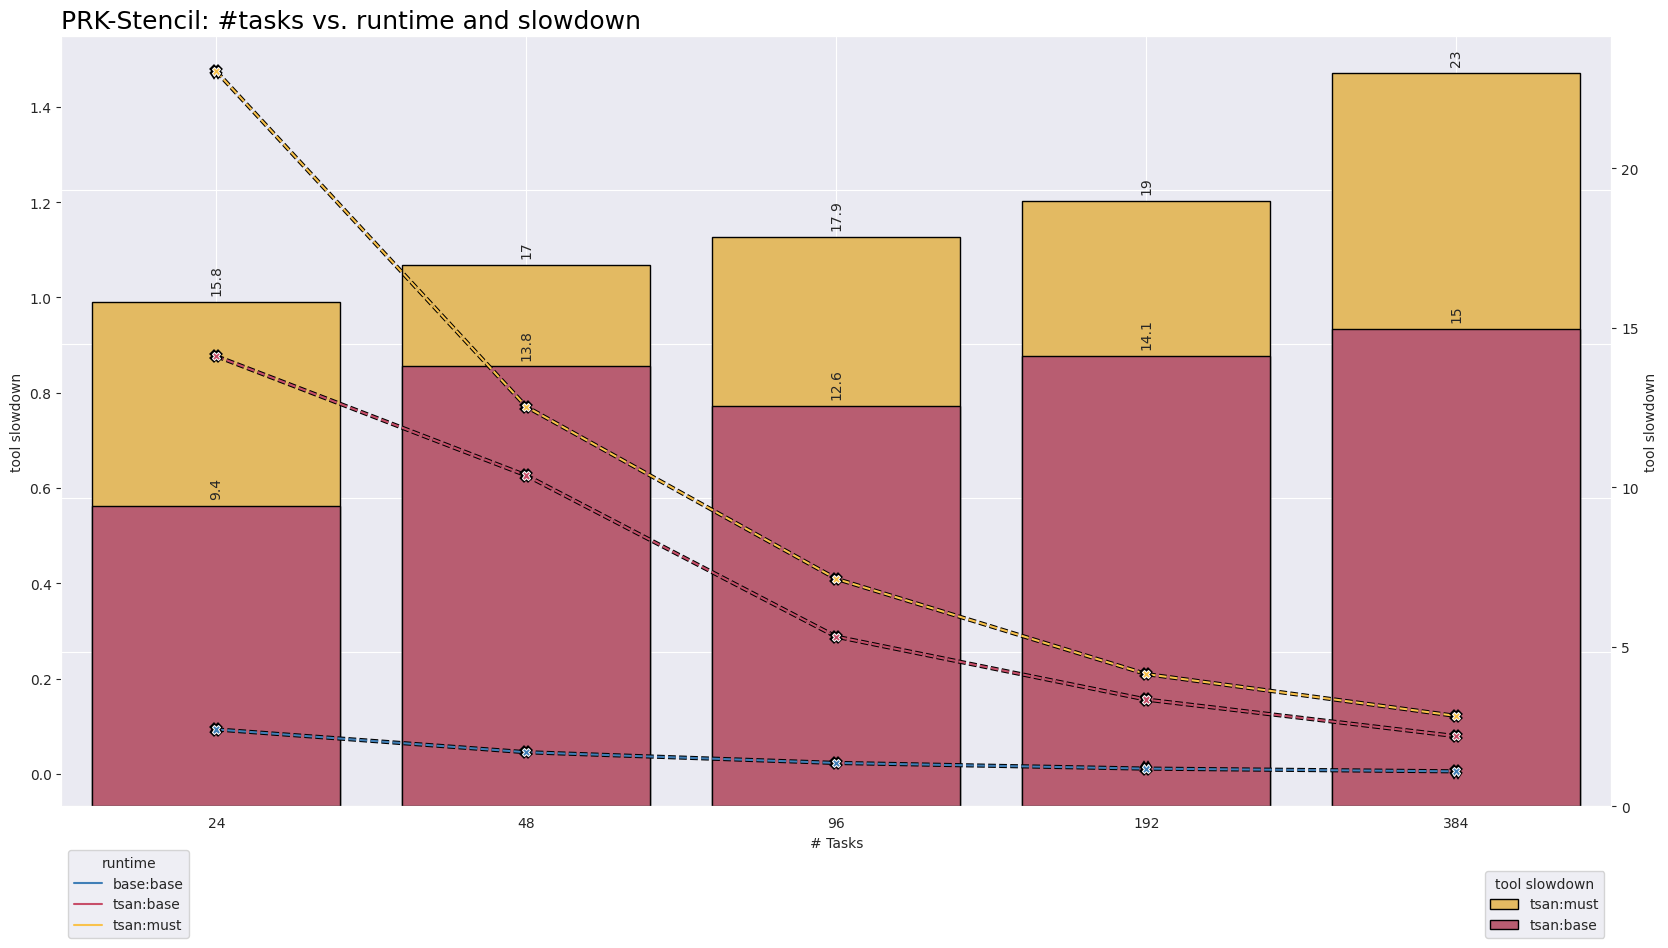

<Figure size 640x480 with 0 Axes>

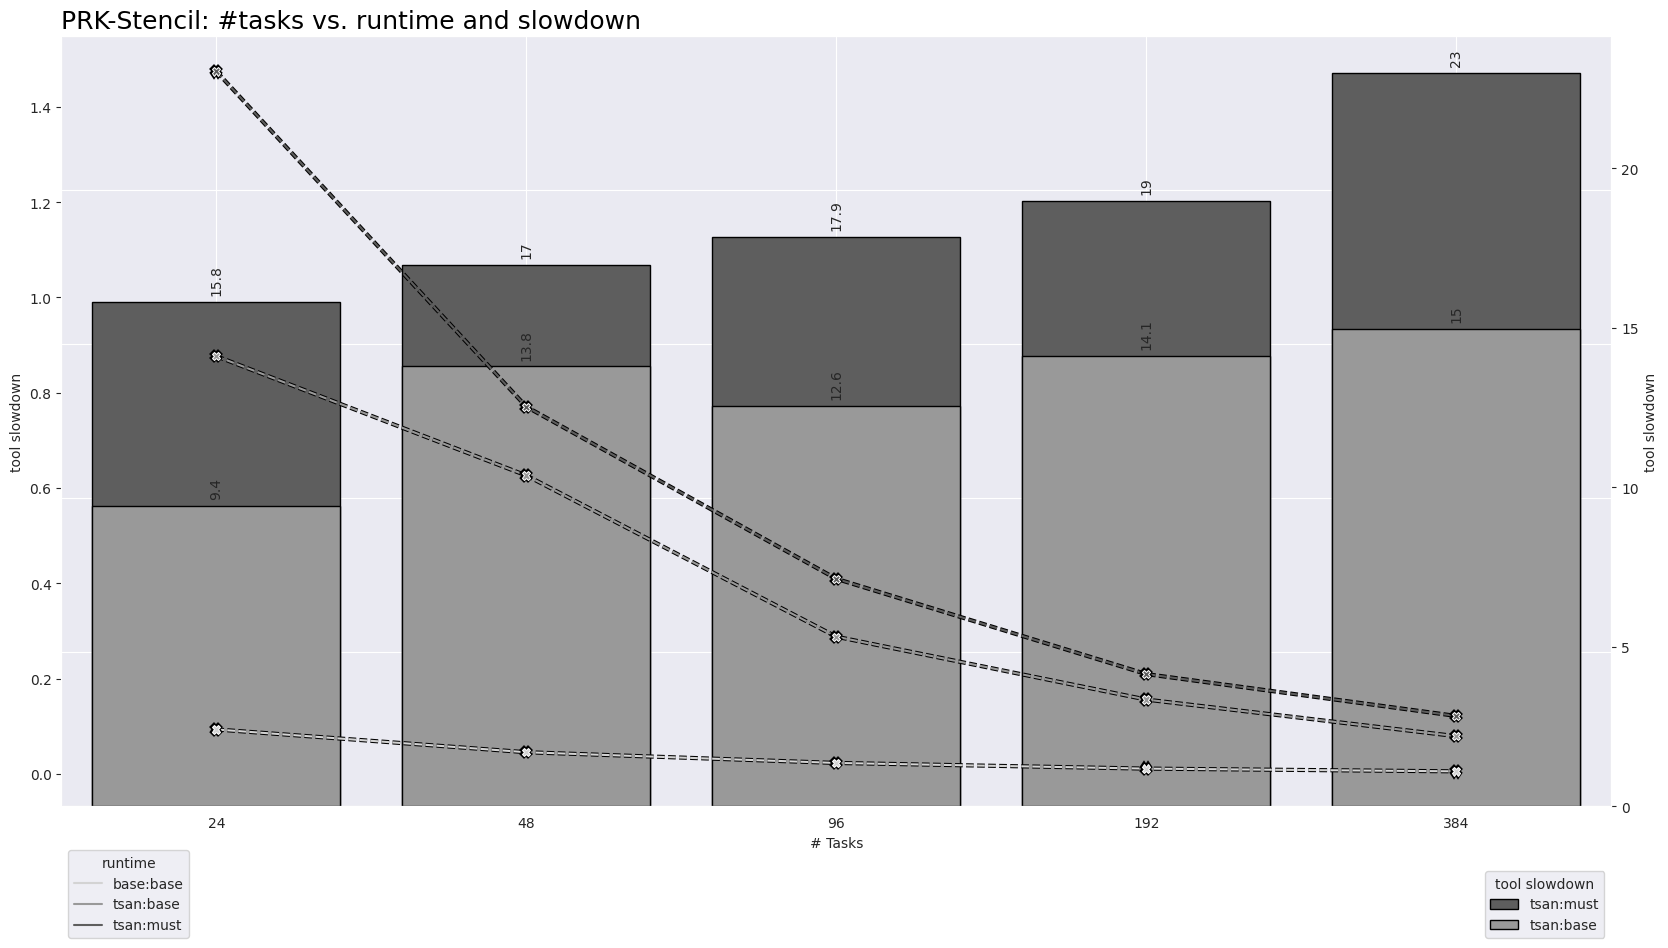

In [13]:
# cat_lineplot can be a little bit more contrasting when the points are over the bars. path_effects seems to help the line to stick out, but the lines now become the focus...
plot(runtime=cat_lineplot, slowdown=overlapping_barplot, primary="slowdown", runtime_kwargs={"marker":"X", "linestyle":"--", "path_effects":[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]}, slowdown_kwargs={"edgecolor":"black"})
plot(runtime=cat_lineplot, slowdown=overlapping_barplot, primary="slowdown", runtime_kwargs={"marker":"X", "linestyle":"--", "path_effects":[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]}, slowdown_kwargs={"edgecolor":"black"}, palette=greyscale)

## Scatterplot with varying point sizes

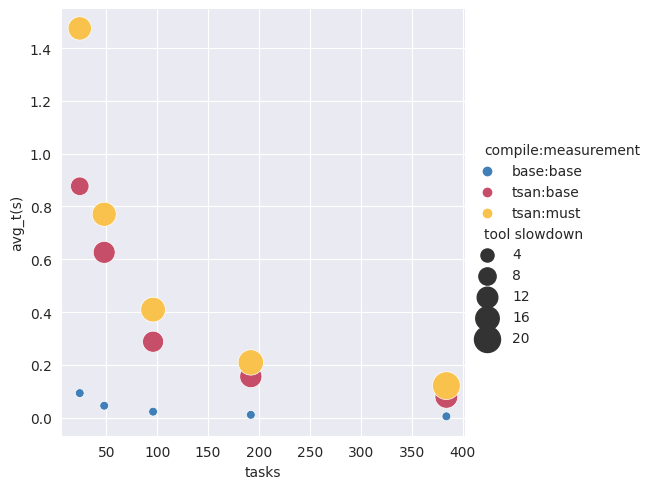

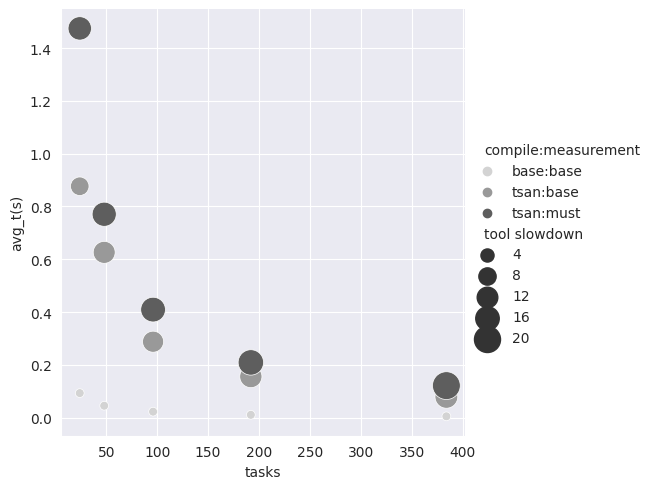

In [14]:
tmp1 = df.copy()
#drop base:must
tmp1 = tmp1.drop(tmp1[tmp1["compile:measurement"] == "base:must"].index)

sns.relplot(x="tasks", y=time_col, data=tmp1, hue="compile:measurement", size=slowdown_col, sizes=(40,400), palette=colorful)
plt.show()
sns.relplot(x="tasks", y=time_col, data=tmp1, hue="compile:measurement", size=slowdown_col, sizes=(40,400), palette=greyscale)
plt.show()


# Optimized Tsan 

## Creating artificial data

In [15]:
df_test1 = df.copy()
df_test2 = df.copy()
df_test2 = df_test2.loc[(df_test2["compile"] == "tsan")]
df_test2["compile:measurement"] = df_test2["compile"]+ ".opti" + ":" + df_test2["measurement"]
df_test2["avg_t(s)"] = [t/2 for t in df_test2["avg_t(s)"]]

#Combine dataframes
result = pd.concat([df_test1, df_test2])

#recalculate slowdowns
#result["slowdown"] = [row["avg_t(s)"]/result.loc[(result['compile'] == "base") & (result['measurement'] == "base") & (result['tasks'] == result['tasks'].min())]["avg_t(s)"].iloc[0] for index, row in result.iterrows()]
result["tool slowdown"] = [row["avg_t(s)"]/result.loc[(result['compile'] == "base") & (result['measurement'] == "base") & (result['tasks'] == row['tasks'])]["avg_t(s)"].iloc[0] for index, row in result.iterrows()]

#sort values
result.sort_values(by=["tasks", "measurement"], inplace=True)
result.reset_index(drop=True, inplace=True)
result

bench_id compile measurement  tasks  num_iters  grid_size  avg_t(s)  \
0         41    base        base     24        400      20000  0.093211   
1         41    tsan        base     24        400      20000  0.876520   
2         41    tsan        base     24        400      20000  0.438260   
3         41    tsan        must     24        400      20000  1.474257   
4         41    tsan        must     24        400      20000  0.737128   
5         41    base        base     48        400      20000  0.045422   
6         41    tsan        base     48        400      20000  0.626195   
7         41    tsan        base     48        400      20000  0.313097   
8         41    tsan        must     48        400      20000  0.770547   
9         41    tsan        must     48        400      20000  0.385273   
10        41    base        base     96        400      20000  0.022924   
11        41    tsan        base     96        400      20000  0.287862   
12        41    tsan        base     96        400      20000  0.143931   
13        41    tsan        must     96        400      20000  0.409369   
14        41    tsan        must     96        400      20000  0.204684   
15        41    base        base    192        400      20000  0.011040   
16        41    tsan        base    192        400      20000  0.155908   
17        41    tsan        base    192        400      20000  0.077954   
18        41    tsan        must    192        400      20000  0.209394   
19        41    tsan        must    192        400      20000  0.104697   
20        41    base        base    384        400      20000  0.005288   
21        41    tsan        base    384        400      20000  0.079069   
22        41    tsan        base    384        400      20000  0.039535   
23        41    tsan        must    384        400      20000  0.121535   
24        41    tsan        must    384        400      20000  0.060768   

    rate (MFlops/s)  tool slowdown compile:measurement  
0      47195.414773       1.000000           base:base  
1       5018.848593       9.403611           tsan:base  
2       5018.848593       4.701806      tsan.opti:base  
3       2983.956428      15.816341           tsan:must  
4       2983.956428       7.908171      tsan.opti:must  
5      96850.042577       1.000000           base:base  
6       7025.158598      13.786161           tsan:base  
7       7025.158598       6.893080      tsan.opti:base  
8       5709.090651      16.964180           tsan:must  
9       5709.090651       8.482090      tsan.opti:must  
10    191899.157068       1.000000           base:base  
11     15282.055308      12.557233           tsan:base  
12     15282.055308       6.278616      tsan.opti:base  
13     10746.112400      17.857660           tsan:must  
14     10746.112400       8.928830      tsan.opti:must  
15    398474.354788       1.000000           base:base  
16     28216.100553      14.122101           tsan:base  
17     28216.100553       7.061051      tsan.opti:base  
18     21008.772344      18.966848           tsan:must  
19     21008.772344       9.483424      tsan.opti:must  
20    831945.953164       1.000000           base:base  
21     55636.650885      14.952534           tsan:base  
22     55636.650885       7.476267      tsan.opti:base  
23     36196.216854      22.983169           tsan:must  
24     36196.216854      11.491585      tsan.opti:must

## Adding barplot plotting method that further groups the groups of a grouped barplot

In [16]:
# We need some more colors
colors_tsan_opti = ["#407fb7", "#c74e69", "#e78a9f", "#f9c24c", "#FBDA93"]
hatch_tsan_opti  = ["", "", "\\\\", "", "\\\\"]

def grouped_grouped_barplot(ax, target, **kwargs): 
    #Plot the bars
    grouped_barplot(ax, target, **kwargs)
    
    ## Do not spread the groups too far appart, or otherwise you will get problems with the gestalt law of proximity, i.e., it might become difficult to tell what groupings belong together
    ## The following is just a quick and dirty approach to seperate the bars into groups of two, but it hopefully presents the rought idea how to do it.
    ## This probabaly only works correct with 4 bars per grouping and a correctly sorted dataframe. We separate the bars by the plotting order and not by the combination of compile and measurement features
    # get dataframe
    df = kwargs["data"].copy()
    ntasks = df["tasks"].nunique() # number of bars of a specific color
    offset = 1/80
    for i, bar in enumerate(ax.patches):
        #shrink the bar a little bit
        bar.set_width(bar.get_width()-2*offset)
        #move the bar to left or right
        if i < ntasks:                      #first color, i.e. all bars that have the first color get moved here
            bar.set_x(bar.get_x()+offset)
        elif i < 2*ntasks:                  #second color
            bar.set_x(bar.get_x()-offset)
        elif i < 3*ntasks:                  #third color
            bar.set_x(bar.get_x()+offset)
        else:                               #fourth color
            bar.set_x(bar.get_x()-offset)
        #move the bar to the right to center them on the tick
        bar.set_x(bar.get_x()+offset)

<Figure size 640x480 with 0 Axes>

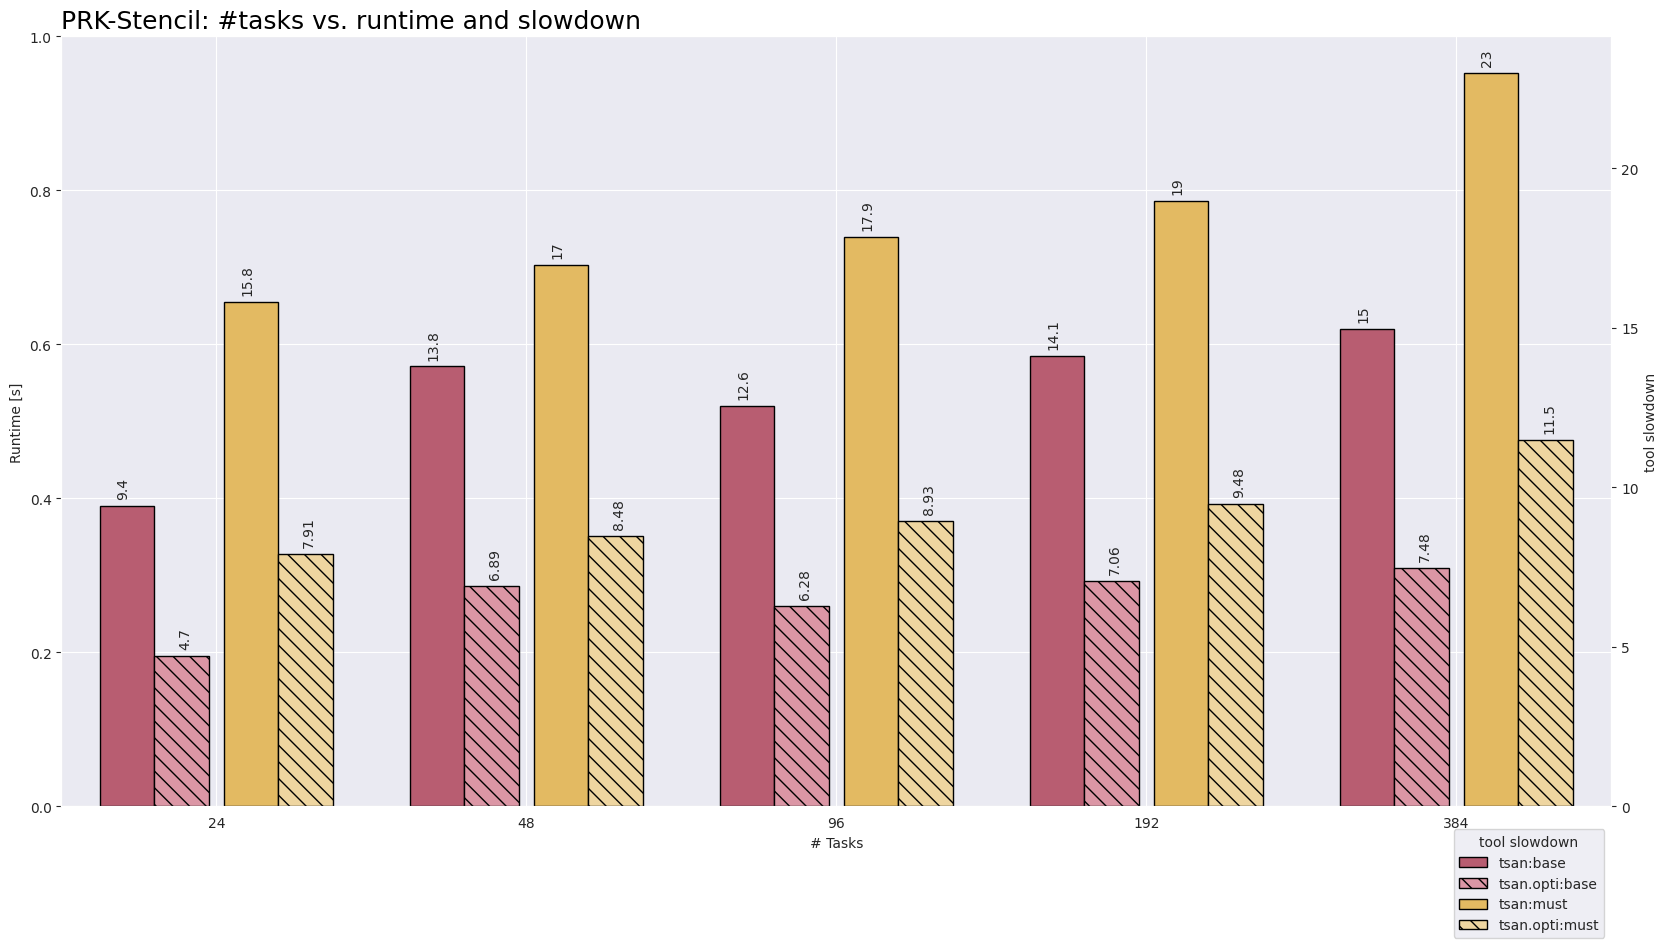

In [17]:
plot(runtime=None, slowdown=grouped_grouped_barplot, edgecolor="black", data=result, palette=colors_tsan_opti, hatch=hatch_tsan_opti)
#plot(runtime=None, slowdown=grouped_grouped_barplot, palette=greyscale, edgecolor="black", data=result, hatch=hatch_tsan_opti)